In [3]:
import mopdbrs2

In [4]:
import pg8000

In [5]:
creds = mopdbrs2.get_creds()

creds['ssl_context']=True

con = pg8000.connect(**creds) 


/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'midway-auth.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readth

In [6]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from dateutil.parser import parse
import math
import random 

In [7]:
sql = """

WITH pka_dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
      AND shipping_address_country_code = 'CA'
      AND ship_week < '2021-05-02'
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, GETDATE())))))
      AND marketplace_id=7
    UNION
     SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_date)))) AS ship_week
    ,SUBSTRING(destination_postal_code,1,3) AS zipcode
    ,fulfillment_shipment_id AS OTM_OBCUST_PKG_REC_ID
    ,originating_fulfillment_center AS warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM perfectmile_ext.d_perfectmile_pkg_attributes_v2_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(originating_fulfillment_center) NOT IN ('PTOP')
      AND destination_country_code = 'CA'
      AND ship_week < trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, GETDATE()))))
      AND ship_week >= '2021-05-02'
      AND marketplace_id=7
    )


SELECT ship_week
    ,pka_dosp.zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
FROM pka_dosp
    INNER JOIN trans_dims_ddl.warehouses w
    ON pka_dosp.warehouse_id = w.warehouse_id
    AND w.legal_entity_id = 115
    AND w.is_sortcenter = 'N'                                           
    AND w.is_prime_now = 'N'                                            
    AND w.is_fresh = 'N'
    and zipcode in (select "left"(destination_postal_code,3) as fsa
from perfectmile.d_perfectmile_pkg_attributes_v2_na
where marketplace_id = 7
and ship_date >= to_date('20200101','YYYYMMDD')
and not(left(fsa,1) ~ '^[0-9]')
group by 1
having count(*) > 1000)
GROUP BY 1,
         2
ORDER BY 1,2;
    
    """


In [8]:
mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
mod_df

zipcode  pkgs
ship_week               
2017-07-16     A0A   304
2017-07-16     A0B   162
2017-07-16     A0C    77
2017-07-16     A0E   184
2017-07-16     A0G   309
...            ...   ...
2021-08-01     X0G     4
2021-08-01     X1A  2246
2021-08-01     Y0A    13
2021-08-01     Y0B    47
2021-08-01     Y1A  3175

[348692 rows x 2 columns]

In [9]:
mod_df.to_csv('mod_df.csv')

In [10]:
mod_df = pd.read_csv(r'mod_data/mod_df.csv', parse_dates=['ship_week'], index_col='ship_week')
print(mod_df)

           zipcode  pkgs
ship_week               
2017-07-16     A0A   304
2017-07-16     A0B   162
2017-07-16     A0C    77
2017-07-16     A0E   184
2017-07-16     A0G   309
...            ...   ...
2021-08-01     X0G     4
2021-08-01     X1A  2246
2021-08-01     Y0A    13
2021-08-01     Y0B    47
2021-08-01     Y1A  3175

[348692 rows x 2 columns]


In [11]:
len(mod_df.zipcode.unique())

1653

In [12]:
mod_df.reset_index()
#mod_df.describe()

ship_week zipcode  pkgs
0      2017-07-16     A0A   304
1      2017-07-16     A0B   162
2      2017-07-16     A0C    77
3      2017-07-16     A0E   184
4      2017-07-16     A0G   309
...           ...     ...   ...
348687 2021-08-01     X0G     4
348688 2021-08-01     X1A  2246
348689 2021-08-01     Y0A    13
348690 2021-08-01     Y0B    47
348691 2021-08-01     Y1A  3175

[348692 rows x 3 columns]

In [11]:
mod_v0_rst = mod_df.reset_index()

In [12]:
mod_df.describe()

pkgs
count  348675.00000
mean     2071.94907
std      2610.45082
min         1.00000
25%       482.00000
50%      1211.00000
75%      2657.00000
max     44110.00000

## New V0

In [13]:
mask_v0 = (mod_v0_rst['ship_week'] >= '2019-07-21') & (mod_v0_rst['ship_week'] <= '2020-07-21')
print(mod_v0_rst.loc[mask_v0])

        ship_week zipcode  pkgs
173639 2019-07-21     A0A   822
173640 2019-07-21     A0B   428
173641 2019-07-21     A0C   262
173642 2019-07-21     A0E   455
173643 2019-07-21     A0G   839
...           ...     ...   ...
261116 2020-07-19     X0G     4
261117 2020-07-19     X1A  3206
261118 2020-07-19     Y0A    15
261119 2020-07-19     Y0B    59
261120 2020-07-19     Y1A  3858

[87482 rows x 3 columns]


In [14]:
df_v0_new = mod_v0_rst.loc[mask_v0]
df_v0_new

ship_week zipcode  pkgs
173639 2019-07-21     A0A   822
173640 2019-07-21     A0B   428
173641 2019-07-21     A0C   262
173642 2019-07-21     A0E   455
173643 2019-07-21     A0G   839
...           ...     ...   ...
261116 2020-07-19     X0G     4
261117 2020-07-19     X1A  3206
261118 2020-07-19     Y0A    15
261119 2020-07-19     Y0B    59
261120 2020-07-19     Y1A  3858

[87482 rows x 3 columns]

In [15]:
train_pct = df_v0_new.groupby(['ship_week','zipcode']).sum()/df_v0_new.groupby(['ship_week']).sum()
train_pct 

pkgs
ship_week  zipcode              
2019-07-21 A0A      3.246471e-04
           A0B      1.690377e-04
           A0C      1.034763e-04
           A0E      1.797013e-04
           A0G      3.313612e-04
...                          ...
2020-07-19 X0G      7.749190e-07
           X1A      6.210976e-04
           Y0A      2.905946e-06
           Y0B      1.143005e-05
           Y1A      7.474093e-04

[87482 rows x 1 columns]

In [16]:
train_pct_rst = train_pct.reset_index()
train_pct_rst

ship_week zipcode          pkgs
0     2019-07-21     A0A  3.246471e-04
1     2019-07-21     A0B  1.690377e-04
2     2019-07-21     A0C  1.034763e-04
3     2019-07-21     A0E  1.797013e-04
4     2019-07-21     A0G  3.313612e-04
...          ...     ...           ...
87477 2020-07-19     X0G  7.749190e-07
87478 2020-07-19     X1A  6.210976e-04
87479 2020-07-19     Y0A  2.905946e-06
87480 2020-07-19     Y0B  1.143005e-05
87481 2020-07-19     Y1A  7.474093e-04

[87482 rows x 3 columns]

In [291]:
train_pct.loc[pd.to_datetime('2019-07-21')].pkgs.sum()

1.0

In [17]:
train_avg= train_pct.groupby(['zipcode'], sort=False).mean()
train_avg

pkgs
zipcode          
A0A      0.000366
A0B      0.000187
A0C      0.000100
A0E      0.000197
A0G      0.000348
...           ...
X0G      0.000001
X1A      0.000623
Y0A      0.000003
Y0B      0.000012
Y1A      0.000781

[1653 rows x 1 columns]

In [281]:
train_avg['pkgs'].sum()

1.0000063734960531

In [18]:
train_avg_rst = train_avg.reset_index()
train_avg_rst

zipcode      pkgs
0        A0A  0.000366
1        A0B  0.000187
2        A0C  0.000100
3        A0E  0.000197
4        A0G  0.000348
...      ...       ...
1648     X0G  0.000001
1649     X1A  0.000623
1650     Y0A  0.000003
1651     Y0B  0.000012
1652     Y1A  0.000781

[1653 rows x 2 columns]

In [50]:
pct_data2 = pct2.reset_index()
pct_data2.head(10)

ship_week zipcode      pkgs
0 2017-07-09     A0A  0.000331
1 2017-07-09     A0B  0.000172
2 2017-07-09     A0C  0.000090
3 2017-07-09     A0E  0.000167
4 2017-07-09     A0G  0.000286
5 2017-07-09     A0H  0.000174
6 2017-07-09     A0J  0.000106
7 2017-07-09     A0K  0.000166
8 2017-07-09     A0L  0.000087
9 2017-07-09     A0M  0.000064

## New V0 MAPE

In [51]:
#actual;pkgs_x and v0; pkgs_y
result_metric_train = pd.merge(pct_data2, train_avg_rst, on=["zipcode"])
result_metric_train 

ship_week zipcode    pkgs_x    pkgs_y
0      2017-07-09     A0A  0.000331  0.000366
1      2017-07-16     A0A  0.000314  0.000366
2      2017-07-23     A0A  0.000321  0.000366
3      2017-07-30     A0A  0.000360  0.000366
4      2017-08-06     A0A  0.000392  0.000366
...           ...     ...       ...       ...
348670 2021-06-27     R5R  0.000033  0.000024
348671 2021-07-04     R5R  0.000038  0.000024
348672 2021-07-11     R5R  0.000037  0.000024
348673 2021-07-18     R5R  0.000040  0.000024
348674 2021-07-25     R5R  0.000039  0.000024

[348675 rows x 4 columns]

In [52]:
result_metric_train['APE_V0_new'] = result_metric_train ['pkgs_x'] - result_metric_train ['pkgs_y']

result_metric_train['APE_V0_new']= result_metric_train ['APE_V0_new'].abs()

result_metric_train.head()

ship_week zipcode    pkgs_x    pkgs_y  APE_V0_new
0 2017-07-09     A0A  0.000331  0.000366    0.000035
1 2017-07-16     A0A  0.000314  0.000366    0.000052
2 2017-07-23     A0A  0.000321  0.000366    0.000045
3 2017-07-30     A0A  0.000360  0.000366    0.000006
4 2017-08-06     A0A  0.000392  0.000366    0.000026

In [53]:
result_metric_train['APE_V0'] = result_metric_train['APE_V0_new'] / result_metric_train['pkgs_x']
result_metric_train

ship_week zipcode    pkgs_x    pkgs_y  APE_V0_new    APE_V0
0      2017-07-09     A0A  0.000331  0.000366    0.000035  0.106163
1      2017-07-16     A0A  0.000314  0.000366    0.000052  0.165161
2      2017-07-23     A0A  0.000321  0.000366    0.000045  0.140000
3      2017-07-30     A0A  0.000360  0.000366    0.000006  0.015527
4      2017-08-06     A0A  0.000392  0.000366    0.000026  0.066949
...           ...     ...       ...       ...         ...       ...
348670 2021-06-27     R5R  0.000033  0.000024    0.000010  0.287883
348671 2021-07-04     R5R  0.000038  0.000024    0.000014  0.372586
348672 2021-07-11     R5R  0.000037  0.000024    0.000013  0.358503
348673 2021-07-18     R5R  0.000040  0.000024    0.000016  0.397938
348674 2021-07-25     R5R  0.000039  0.000024    0.000015  0.388099

[348675 rows x 6 columns]

In [54]:
#MAPE
mean_train_V0=result_metric_train.groupby(['ship_week'])[['APE_V0']].mean()*100
mean_train_V0

APE_V0
ship_week            
2017-07-09  22.996295
2017-07-16  19.759806
2017-07-23  19.150535
2017-07-30  17.997751
2017-08-06  17.022993
...               ...
2021-06-27  22.066583
2021-07-04  19.404626
2021-07-11  18.749962
2021-07-18  18.597095
2021-07-25  19.980562

[212 rows x 1 columns]

In [55]:
mape_v0_upd = mean_train_V0[mean_train_V0.index >'2020-07-04']
mape_v0_upd

APE_V0
ship_week            
2020-07-05  14.022005
2020-07-12  14.664827
2020-07-19  13.745577
2020-07-26  14.679584
2020-08-02  16.213480
2020-08-09  13.988154
2020-08-16  14.055621
2020-08-23  14.078862
2020-08-30  12.713263
2020-09-06  13.894015
2020-09-13  11.885826
2020-09-20  11.704594
2020-09-27  11.821341
2020-10-04  13.524632
2020-10-11  17.031718
2020-10-18  14.289809
2020-10-25  13.669669
2020-11-01  17.061141
2020-11-08  16.962115
2020-11-15  17.587439
2020-11-22  17.390502
2020-11-29  18.634506
2020-12-06  18.287448
2020-12-13  26.885003
2020-12-20  38.223670
2020-12-27  26.196034
2021-01-03  23.607900
2021-01-10  25.896623
2021-01-17  26.259586
2021-01-24  25.286459
2021-01-31  25.003485
2021-02-07  23.279032
2021-02-14  19.484874
2021-02-21  18.056545
2021-02-28  17.068319
2021-03-07  16.635062
2021-03-14  18.033121
2021-03-21  15.607554
2021-03-28  21.454006
2021-04-04  20.508213
2021-04-11  21.637148
2021-04-18  22.765641
2021-04-25  22.637595
2021-05-02  23.803364
2021-05-09  22.265145
2021-05-16  21.802387
2021-05-23  22.837347
2021-05-30  21.632239
2021-06-06  18.795396
2021-06-13  19.270580
2021-06-20  17.601245
2021-06-27  22.066583
2021-07-04  19.404626
2021-07-11  18.749962
2021-07-18  18.597095
2021-07-25  19.980562

In [ ]:
# mask_mape = (mean_train_V0['ship_week'] >= '2019-07-21') & (mean_train_V0['ship_week'] <= '2020-07-21')
# print(mod_v0_rst.loc[mask_v0])

## NEW V0 WAPE

In [56]:
result_train_wape = pd.merge(pct_data2, train_avg_rst, on=["zipcode"])
result_train_wape

ship_week zipcode    pkgs_x    pkgs_y
0      2017-07-09     A0A  0.000331  0.000366
1      2017-07-16     A0A  0.000314  0.000366
2      2017-07-23     A0A  0.000321  0.000366
3      2017-07-30     A0A  0.000360  0.000366
4      2017-08-06     A0A  0.000392  0.000366
...           ...     ...       ...       ...
348670 2021-06-27     R5R  0.000033  0.000024
348671 2021-07-04     R5R  0.000038  0.000024
348672 2021-07-11     R5R  0.000037  0.000024
348673 2021-07-18     R5R  0.000040  0.000024
348674 2021-07-25     R5R  0.000039  0.000024

[348675 rows x 4 columns]

In [57]:
result_train_wape['APE_new'] = result_train_wape ['pkgs_x'] - result_train_wape ['pkgs_y']

result_train_wape['APE_new']= result_train_wape ['APE_new'].abs()

result_train_wape.head()

ship_week zipcode    pkgs_x    pkgs_y   APE_new
0 2017-07-09     A0A  0.000331  0.000366  0.000035
1 2017-07-16     A0A  0.000314  0.000366  0.000052
2 2017-07-23     A0A  0.000321  0.000366  0.000045
3 2017-07-30     A0A  0.000360  0.000366  0.000006
4 2017-08-06     A0A  0.000392  0.000366  0.000026

In [58]:
result_train_wape['APE'] = result_train_wape['APE_new'] / result_train_wape['pkgs_x']
result_train_wape

ship_week zipcode    pkgs_x    pkgs_y   APE_new       APE
0      2017-07-09     A0A  0.000331  0.000366  0.000035  0.106163
1      2017-07-16     A0A  0.000314  0.000366  0.000052  0.165161
2      2017-07-23     A0A  0.000321  0.000366  0.000045  0.140000
3      2017-07-30     A0A  0.000360  0.000366  0.000006  0.015527
4      2017-08-06     A0A  0.000392  0.000366  0.000026  0.066949
...           ...     ...       ...       ...       ...       ...
348670 2021-06-27     R5R  0.000033  0.000024  0.000010  0.287883
348671 2021-07-04     R5R  0.000038  0.000024  0.000014  0.372586
348672 2021-07-11     R5R  0.000037  0.000024  0.000013  0.358503
348673 2021-07-18     R5R  0.000040  0.000024  0.000016  0.397938
348674 2021-07-25     R5R  0.000039  0.000024  0.000015  0.388099

[348675 rows x 6 columns]

In [59]:
def my_agg(y):
    names = {'weighted_train_V0': (y['pkgs_x'] * y['APE']).sum()/y['pkgs_x'].sum()}
    return pd.Series(names, index=['weighted_train_V0'])

In [60]:
wape_V0_new = result_train_wape.groupby(["ship_week"]).apply(my_agg)*100
wape_V0_new

weighted_train_V0
ship_week                    
2017-07-09          16.449251
2017-07-16          15.526384
2017-07-23          14.938757
2017-07-30          14.544723
2017-08-06          13.963539
...                       ...
2021-06-27          13.779102
2021-07-04          12.259814
2021-07-11          12.385521
2021-07-18          12.397252
2021-07-25          12.817391

[212 rows x 1 columns]

In [61]:
wape_v0_upd = wape_V0_new[wape_V0_new.index >'2020-07-04']
wape_v0_upd

weighted_train_V0
ship_week                    
2020-07-05           8.672484
2020-07-12           8.883869
2020-07-19           8.586769
2020-07-26           8.677768
2020-08-02           9.022317
2020-08-09           7.861131
2020-08-16           8.313361
2020-08-23           7.850879
2020-08-30           7.776116
2020-09-06           8.599217
2020-09-13           7.061386
2020-09-20           7.245004
2020-09-27           7.053660
2020-10-04           8.786329
2020-10-11          10.829006
2020-10-18           9.102842
2020-10-25           8.786383
2020-11-01          10.570533
2020-11-08          11.164210
2020-11-15          12.222311
2020-11-22          11.774883
2020-11-29          12.190559
2020-12-06          12.551219
2020-12-13          15.371633
2020-12-20          20.336910
2020-12-27          14.935325
2021-01-03          15.856741
2021-01-10          18.435781
2021-01-17          18.754559
2021-01-24          17.838923
2021-01-31          16.898594
2021-02-07          15.962682
2021-02-14          12.209857
2021-02-21          11.359980
2021-02-28          10.566548
2021-03-07          10.709170
2021-03-14          11.192711
2021-03-21          10.252243
2021-03-28          13.597722
2021-04-04          12.921975
2021-04-11          14.776203
2021-04-18          15.102838
2021-04-25          14.097487
2021-05-02          15.751171
2021-05-09          15.296077
2021-05-16          15.103282
2021-05-23          14.919324
2021-05-30          15.491082
2021-06-06          13.771100
2021-06-13          12.427121
2021-06-20          11.377921
2021-06-27          13.779102
2021-07-04          12.259814
2021-07-11          12.385521
2021-07-18          12.397252
2021-07-25          12.817391

## Mape plot with updated V0

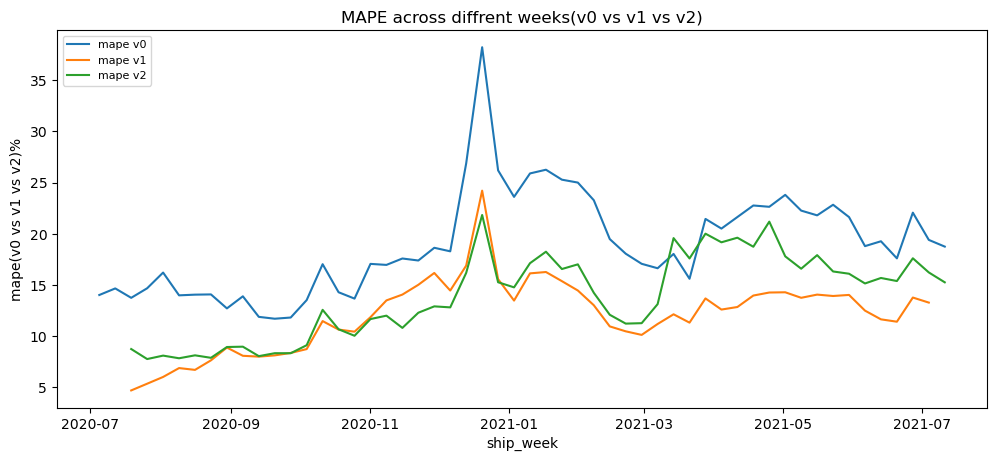

In [179]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mean_result_prop, label='mape v1')
plt.plot(mape_v2, label='mape v2')
plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Update wape plot with v0

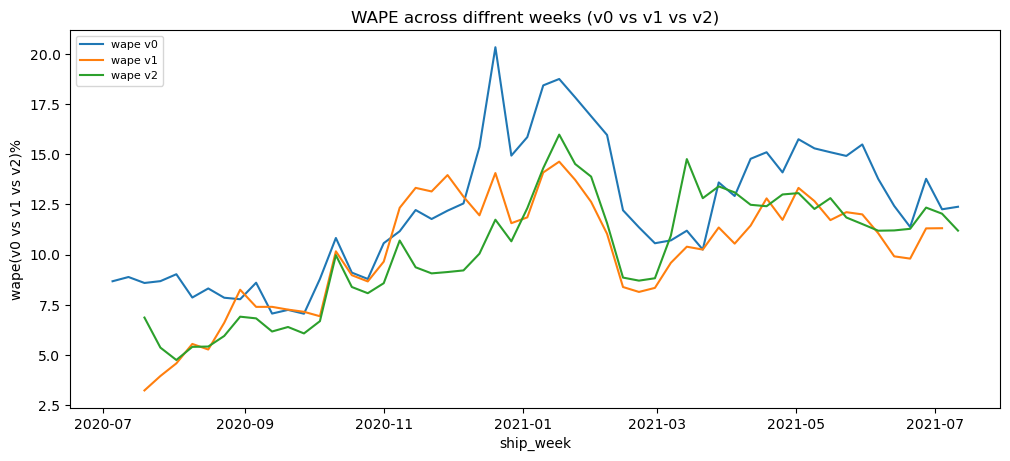

In [180]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_V1, label='wape v1')
plt.plot(wape_v2, label='wape v2')
plt.title('WAPE across diffrent weeks (v0 vs v1 vs v2)')
plt.xlabel('ship_week')
plt.ylabel ('wape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Average

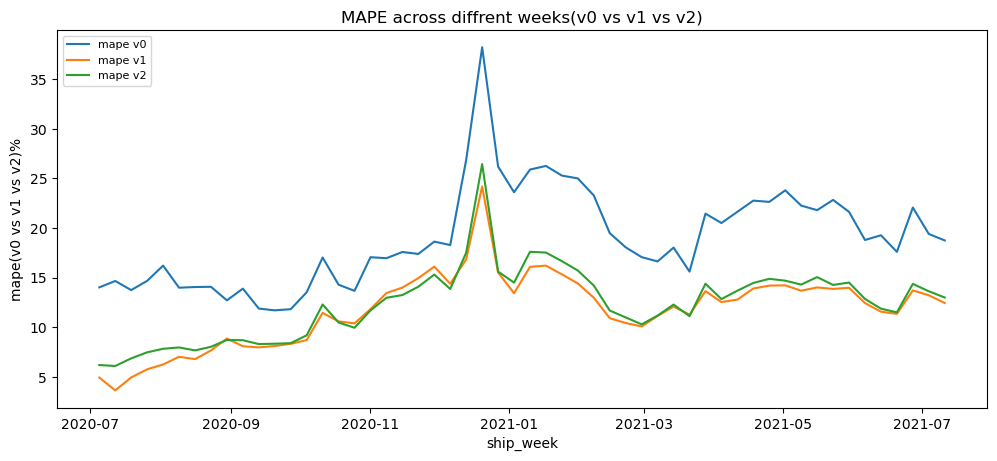

In [160]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mape_v1_upd, label='mape v1')
plt.plot(mape_v2_upd, label='mape v2')
plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

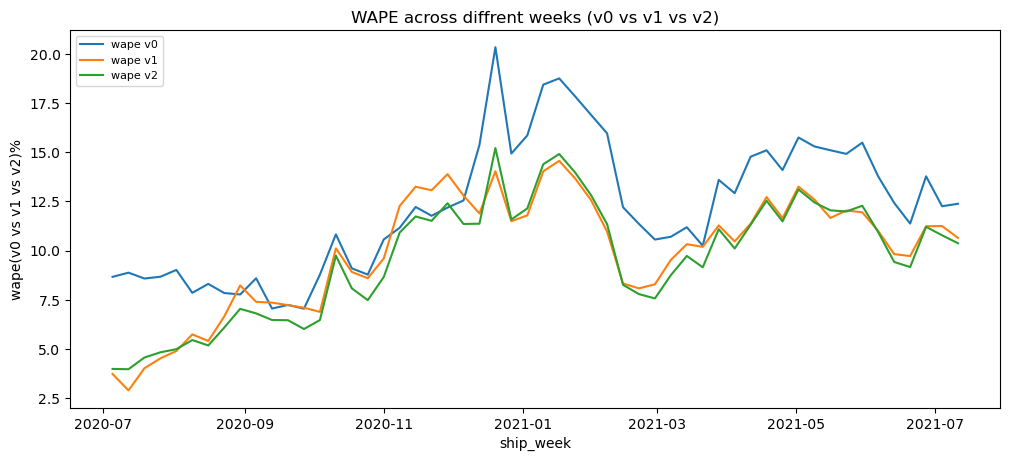

In [178]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_v1_upd, label='wape v1')
plt.plot(wape_new_v2, label='wape v2')
plt.title('WAPE across diffrent weeks (v0 vs v1 vs v2)')
plt.xlabel('ship_week')
plt.ylabel ('wape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
#Percentage short form without 100
FSA = mod_df.groupby(['ship_week','zipcode']).sum()/mod_df.groupby(['ship_week']).sum()
FSA

pkgs
ship_week  zipcode              
2017-07-09 A0A      3.308485e-04
           A0B      1.720708e-04
           A0C      9.009714e-05
           A0E      1.669013e-04
           A0G      2.858000e-04
...                          ...
2021-07-25 X0G      5.808789e-07
           X1A      4.790314e-04
           Y0A      2.904394e-06
           Y0B      9.874941e-06
           Y1A      6.252193e-04

[348675 rows x 1 columns]

In [41]:
FSA.loc[pd.to_datetime('2021-06-13')].pkgs.sum()

1.0

In [42]:
FSA.loc[pd.to_datetime('2017-06-25')].pkgs.sum()

1.0

In [21]:
#% volume distribution/week/FSA
pct1 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()*100
pct1.head()

pkgs
ship_week  zipcode          
2017-07-09 A0A      0.033085
           A0B      0.017207
           A0C      0.009010
           A0E      0.016690
           A0G      0.028580

In [22]:
pct1.loc[pd.to_datetime('2017-07-09')].pkgs.sum()

100.00000000000016

In [23]:
#% volume distribution/week/FSA
pct2 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()
pct2

pkgs
ship_week  zipcode              
2017-07-09 A0A      3.308485e-04
           A0B      1.720708e-04
           A0C      9.009714e-05
           A0E      1.669013e-04
           A0G      2.858000e-04
...                          ...
2021-07-25 X0G      5.808789e-07
           X1A      4.790314e-04
           Y0A      2.904394e-06
           Y0B      9.874941e-06
           Y1A      6.252193e-04

[348675 rows x 1 columns]

In [19]:
pct2.loc[pd.to_datetime('2017-06-25')].pkgs.sum()

1.0000000000000007

In [24]:
pct_data2 = pct2.reset_index()
pct_data2.head(10)

ship_week zipcode      pkgs
0 2017-07-09     A0A  0.000331
1 2017-07-09     A0B  0.000172
2 2017-07-09     A0C  0.000090
3 2017-07-09     A0E  0.000167
4 2017-07-09     A0G  0.000286
5 2017-07-09     A0H  0.000174
6 2017-07-09     A0J  0.000106
7 2017-07-09     A0K  0.000166
8 2017-07-09     A0L  0.000087
9 2017-07-09     A0M  0.000064

In [33]:
pct_data1 = pct1.reset_index() # *100
pct_data1

ship_week zipcode      pkgs
0      2017-06-25     A0A  0.038180
1      2017-06-25     A0B  0.016697
2      2017-06-25     A0C  0.010742
3      2017-06-25     A0E  0.018098
4      2017-06-25     A0G  0.036195
...           ...     ...       ...
348633 2021-07-11     X0G  0.000038
348634 2021-07-11     X1A  0.050325
348635 2021-07-11     Y0A  0.000379
348636 2021-07-11     Y0B  0.001212
348637 2021-07-11     Y1A  0.067144

[348638 rows x 3 columns]

In [25]:
# df = pd.read_excel(r'FSA_Mix/Updated_FSA_Mix.xlsx', engine='openpyxl', sheet_name='FSA Mix %')[['FSA','AMZN Region','City', 'Previous FSA MIX %', 'New FSA MIX %']].dropna()
# print(df)

In [80]:
len(df.FSA.unique())

1661

In [23]:
df1 = df['New FSA MIX %'].sum()
df1

1.0

In [83]:
# df.drop(columns=['City'])
# #df2 = df.rename({'a': 'X', 'b': 'Y'}, axis=1)  # new method

In [26]:
# df2 = df.rename({'FSA': 'zipcode'}, axis=1) 
# df2

In [27]:
# result_metric = pd.merge(pct_data2, df2, on=["zipcode"])
# result_metric

In [28]:
#take the difference
# result_metric['APE_V0'] = result_metric['pkgs'] - result_metric['New FSA MIX %']

# result_metric['APE_V0']= result_metric['APE_V0'].abs()

# result_metric.head()

In [29]:
# result_metric['APE'] = result_metric['APE_V0'] / result_metric['pkgs']*100
# result_metric

<!-- ## V0 MAPE -->

In [30]:
#MAPE
# mean_result_V0=result_metric.groupby(['ship_week'])[['APE']].mean()
# mean_result_V0

In [31]:
# mape_v0 = mean_result_V0[mean_result_V0.index >'2020-07-04']
# mape_v0.head()

In [307]:
# mape_pp_v0 = mape_v0.reset_index()

In [32]:
# pp_v0 = mape_pp_v0[(mape_pp_v0['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# pp_v0

In [309]:
# m_pp_st = pp_v0.set_index('ship_week')

In [33]:
# mean_result_V0[mean_result_V0['APE'] < 10].head()

In [34]:
# mean_result_V0[mean_result_V0['APE'] > 10]

<!-- ## WAPE V0 -->

In [35]:
# result_metric_new = pd.merge(pct_data2, df2, on=["zipcode"])
# result_metric_new

In [36]:
#take the difference
# result_metric_new['APE_V0'] = result_metric_new['pkgs'] - result_metric_new['New FSA MIX %']

# result_metric_new['APE_V0']= result_metric_new['APE_V0'].abs()

# result_metric_new.head()

In [37]:
# result_metric_new['APE'] = result_metric_new['APE_V0'] / result_metric_new['pkgs']
# result_metric_new

In [38]:
# def my_agg(y):
#     names = {'weighted_avg_V0': (y['pkgs'] * y['APE']).sum()/y['pkgs'].sum()}
#     return pd.Series(names, index=['weighted_avg_V0'])

In [39]:
# wape_V0 = result_metric_new.groupby(["ship_week"]).apply(my_agg)*100
# wape_V0

In [28]:
import datetime

In [40]:
# wape_V0[wape_V0.index >'2020-07-04'].head()

In [41]:
# v0 = wape_V0[wape_V0.index >'2020-07-04']
# v0.head()

In [159]:
v0_reset = v0.reset_index()

In [42]:
# wape_pp_v0 = v0_reset[(v0_reset['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# wape_pp_v0

In [161]:
# wape_st_v0 = wape_pp_v0.set_index('ship_week')

In [43]:
# v0_reset = v0.reset_index()
# v0_reset.head()

<!-- ## V1 -->

In [44]:
#mape
# mean_result_prop.head()

In [45]:
# wape_V1.head()

<!-- ## V2 -->

In [46]:
#wape
# wape_v2.head()

In [47]:
#mape
# mape_v2.head()

<!-- ## WAPE PLOTS -->

In [7]:
# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(v0, label='wape v0')
# plt.plot(wape_V1, label='wape v1')
# plt.plot(wape_v2, label='wape v2')
# plt.title('WAPE across diffrent weeks (v0 vs v1 vs v2)')
# plt.xlabel('ship_week')
# plt.ylabel ('wape(v0 vs v1 vs v2)%')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

<!-- ## MAPE PLOTS -->

In [8]:
# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(mape_v0, label='mape v0')
# plt.plot(mean_result_prop, label='mape v1')
# plt.plot(mape_v2, label='mape v2')
# plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
# plt.xlabel ('ship_week')
# plt.ylabel ('mape(v0 vs v1 vs v2)%')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

<!-- ## Prime and peak mnth -->

In [48]:
# pp_v1_m = mape_pp_v1.set_index('ship_week')
# pp_v1_m

In [49]:
# pp_v2_m = mape_pp_v2.set_index('ship_week')
# pp_v2_m

In [112]:
# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(m_pp_st, label='mape v0')
# plt.plot(pp_v1_m, label='mape v1')
# plt.plot(pp_v2_m, label='mape v2')
# plt.title('v0 vs v1 vs v2')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [279]:
pp_st_v2 = wape_pp_v2.set_index('ship_week')

In [280]:
pp_st_v1 = wape_pp_v1.set_index('ship_week')

In [113]:
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(wape_st_v0, label='wape v0')
# plt.plot(pp_st_v1, label='wape v1')
# plt.plot(pp_st_v2, label='wape v2')
# plt.title('v0 vs v1 vs v2')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [128]:
result_metric_new.index.dtype

dtype('int64')

In [148]:
# result_metric_new

In [ ]:
# pct2 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()
# pct2

In [102]:
# result_metric1 = result_metric.groupby(['ship_week'])[['pkgs']].sum()
# result_metric1

In [97]:
# result = pd.merge(pct_data2, df2, left_index=True, right_index=True, how="inner")
# result

In [98]:
# result = pd.merge(pct_data2, df2, left_index=True, right_index=True, how="right")
# result

In [99]:
# #take the difference
# result['APE_diff'] = result['New FSA MIX %'] - result['pkgs']

# result['APE_abs']= result['APE_diff'].abs()

# result.head()

In [100]:
# result['APE'] = result['APE_abs'] / result['pkgs']
# result

In [ ]:
# result_metric = pd.merge(df_fct, mod_reset, on=["zipcode", "ship_week"])
# result_metric

In [101]:
# #MAPE
# mean_result= result.groupby(['ship_week'])[['APE']].mean()
# mean_result

In [101]:
# plt.hist(result['APE'],bins=100)

In [39]:
#merge the old and new dataframes; m and mod_df

# merge_inner = mod_df.merge (df, left_on=['New FSA MIX %', 'AMZN Region'], right_on =['ship_week'])
                       
# merge_inner.head(5)



## Visualize porportions 

In [26]:
#pct_data1[pct_data1['ship_week']=='2017-05-28', '2018-05-28' ].head(8)

## V2 Model for FSA errors

In [32]:
mod_20 = mod_df[(mod_df['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
mod_20

zipcode  pkgs
ship_week               
2017-06-25     B1M    33
2017-06-25     B1W    19
2017-06-25     H3A   750
2017-06-25     H3B   598
2017-06-25     H4T   178
...            ...   ...
2021-07-11     V6C  1245
2021-07-11     V7X    74
2021-07-11     V7Y    76
2021-07-11     X0C   718
2021-07-11     Y0A    20

[4240 rows x 2 columns]

In [33]:
mean_20= mod_20.groupby(['zipcode'], sort=False).mean()
mean_20

pkgs
zipcode             
B1M        98.358491
B1W       173.877358
H3A      1819.250000
H3B      1168.924528
H4T       464.698113
H4Y        17.443396
H4Z        35.867925
H5B        36.863208
K1A       238.070755
K1P       458.254717
L5P         9.646226
M5K       114.933962
M5L        51.863208
M5X       124.179245
T0P        13.429245
V6C      1574.872642
V7X       238.198113
V7Y       174.466981
X0C       178.250000
Y0A        10.929245

In [34]:
mod_20_sum= mod_20.groupby(['zipcode'], sort=False).sum()
mod_20_sum

pkgs
zipcode        
B1M       20852
B1W       36862
H3A      385681
H3B      247812
H4T       98516
H4Y        3698
H4Z        7604
H5B        7815
K1A       50471
K1P       97150
L5P        2045
M5K       24366
M5L       10995
M5X       26326
T0P        2847
V6C      333873
V7X       50498
V7Y       36987
X0C       37789
Y0A        2317

In [35]:
sum_20_sort = mod_20_sum.sort_values('pkgs', ascending=False)
sum_20_sort

pkgs
zipcode        
H3A      385681
V6C      333873
H3B      247812
H4T       98516
K1P       97150
V7X       50498
K1A       50471
X0C       37789
V7Y       36987
B1W       36862
M5X       26326
M5K       24366
B1M       20852
M5L       10995
H5B        7815
H4Z        7604
H4Y        3698
T0P        2847
Y0A        2317
L5P        2045

In [37]:
mod_20_rst = mod_20.reset_index()

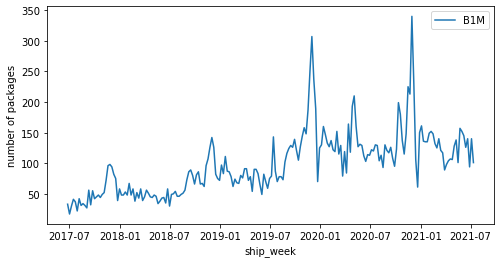

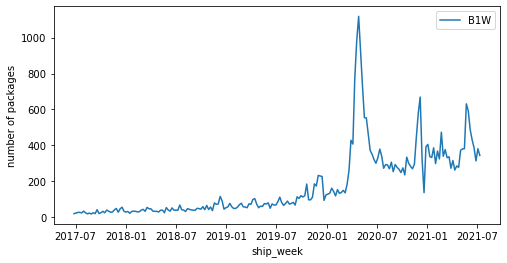

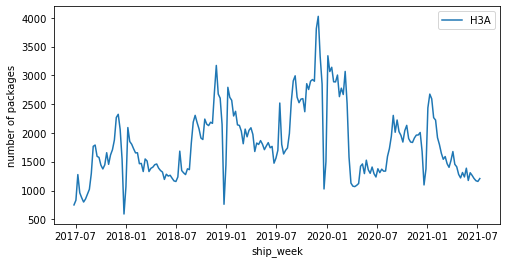

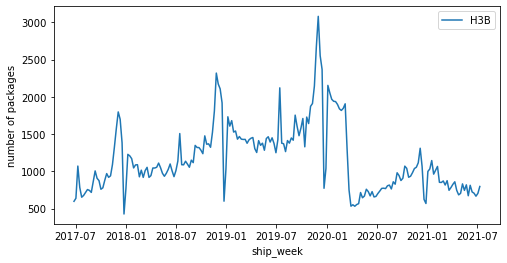

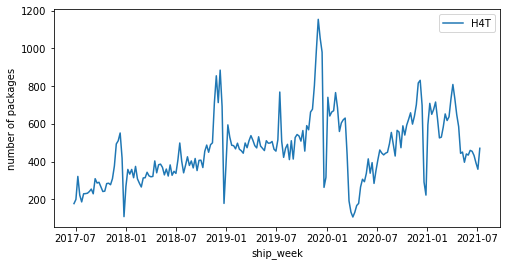

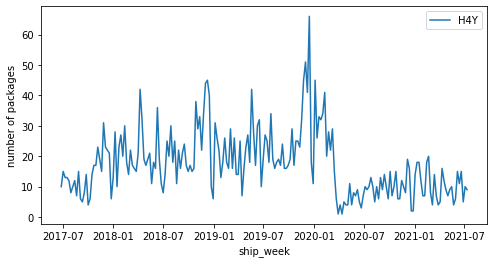

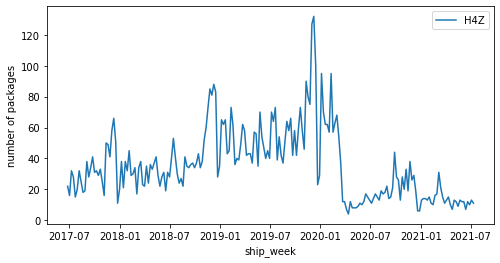

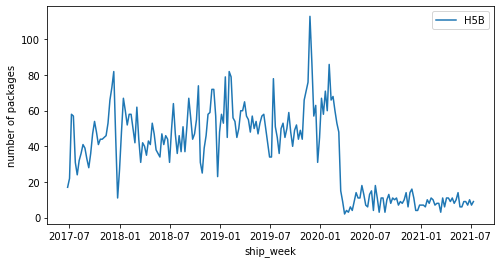

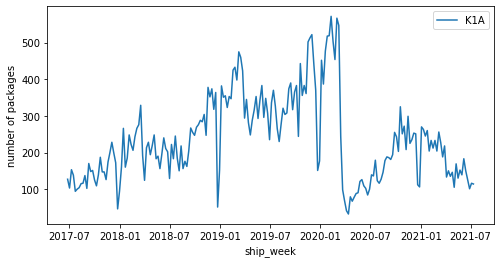

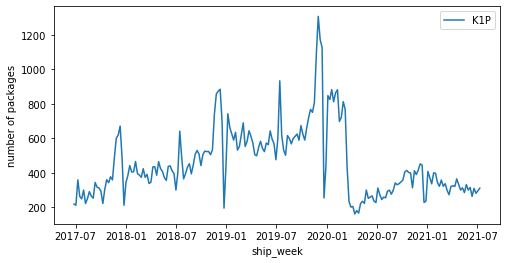

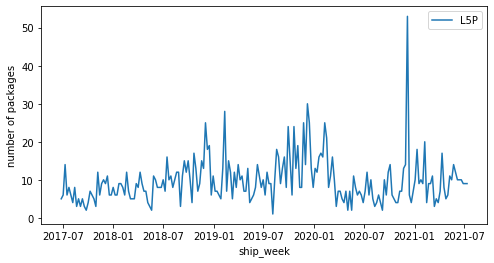

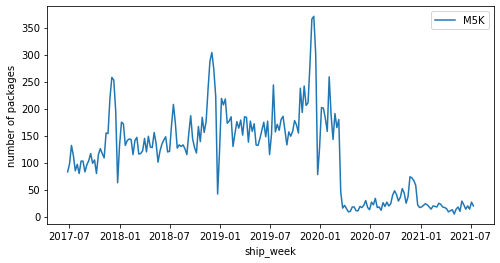

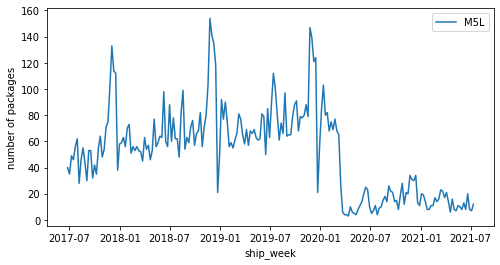

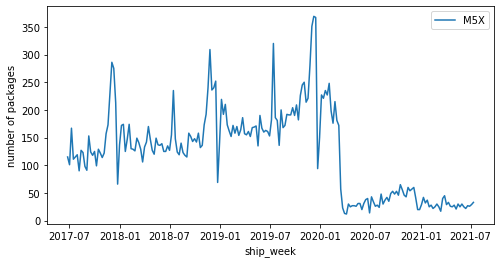

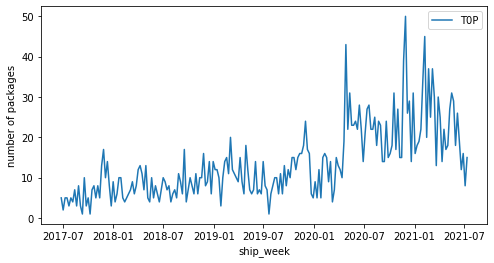

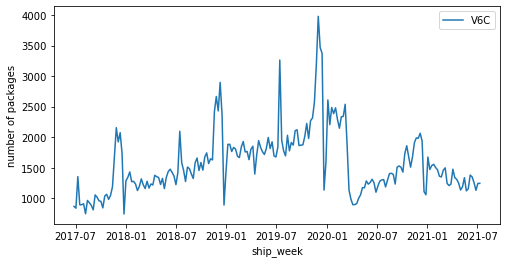

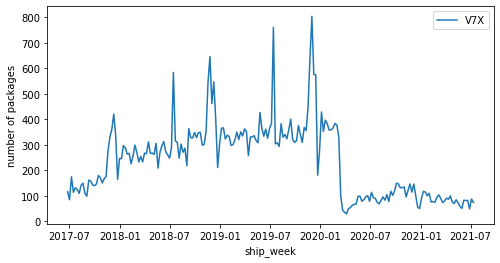

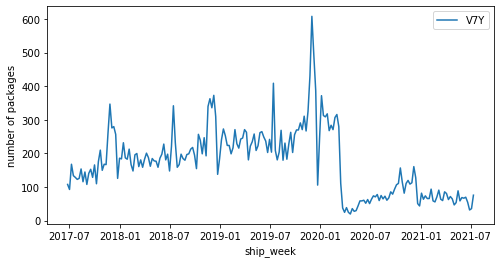

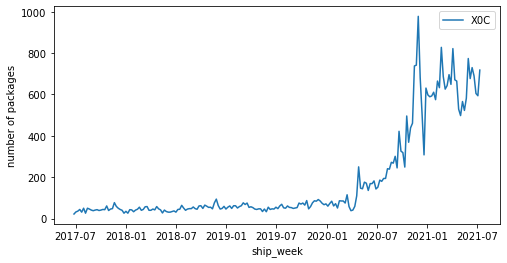

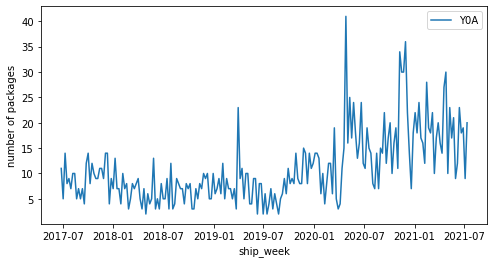

In [38]:
for key, grp in mod_20_rst.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('number of packages')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()

In [39]:
viz_pct_20 = pct_data1[(pct_data1['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
viz_pct_20

ship_week zipcode      pkgs
58     2017-06-25     B1M  0.003853
65     2017-06-25     B1W  0.002218
406    2017-06-25     H3A  0.087569
407    2017-06-25     H3B  0.069822
440    2017-06-25     H4T  0.020783
...           ...     ...       ...
348552 2021-07-11     V6C  0.023581
348587 2021-07-11     V7X  0.001402
348588 2021-07-11     V7Y  0.001439
348631 2021-07-11     X0C  0.013599
348635 2021-07-11     Y0A  0.000379

[4240 rows x 3 columns]

In [40]:
pct_data1

ship_week zipcode      pkgs
0      2017-06-25     A0A  0.038180
1      2017-06-25     A0B  0.016697
2      2017-06-25     A0C  0.010742
3      2017-06-25     A0E  0.018098
4      2017-06-25     A0G  0.036195
...           ...     ...       ...
348633 2021-07-11     X0G  0.000038
348634 2021-07-11     X1A  0.050325
348635 2021-07-11     Y0A  0.000379
348636 2021-07-11     Y0B  0.001212
348637 2021-07-11     Y1A  0.067144

[348638 rows x 3 columns]

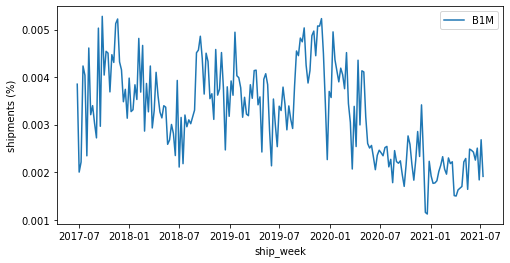

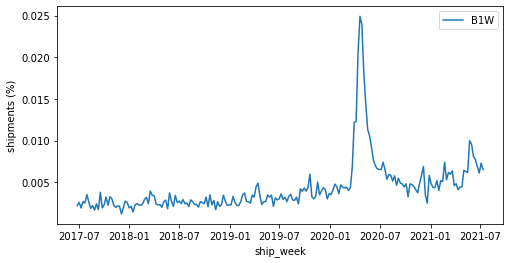

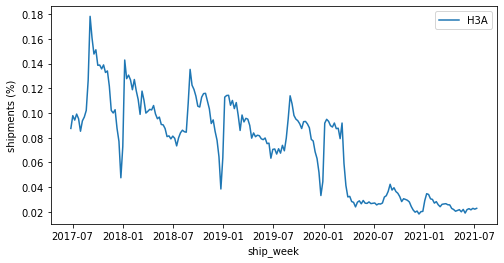

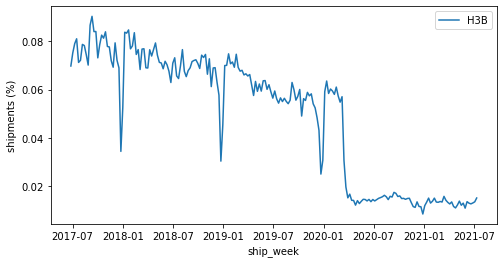

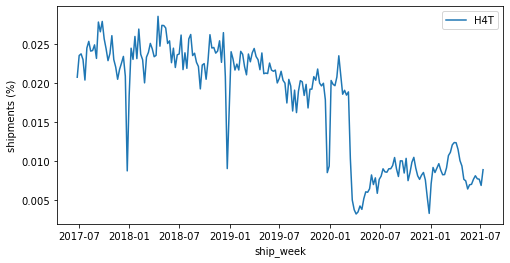

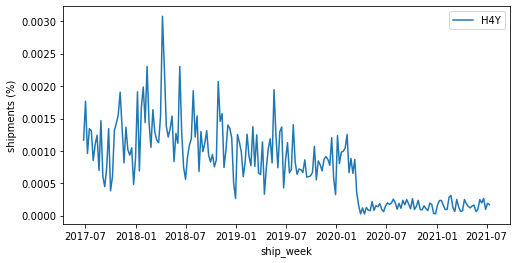

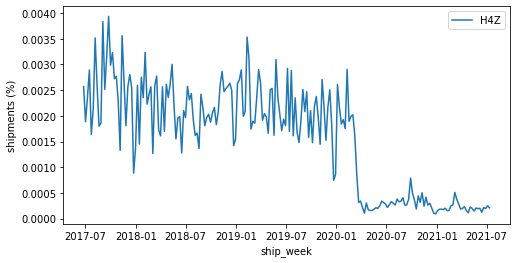

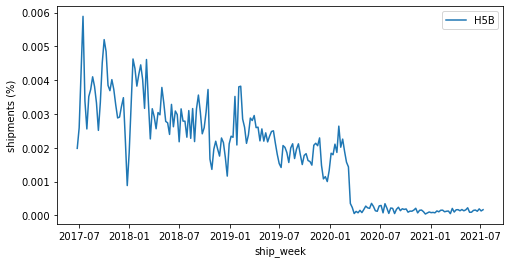

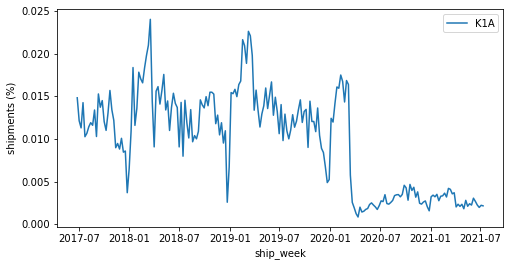

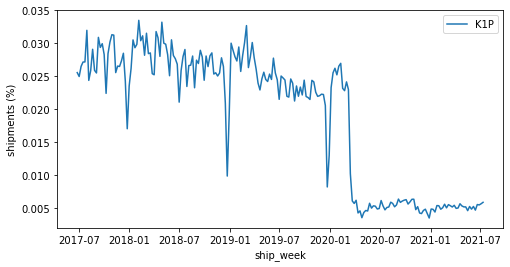

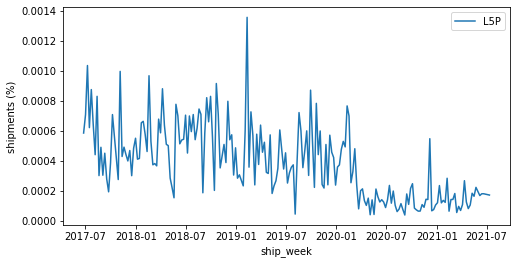

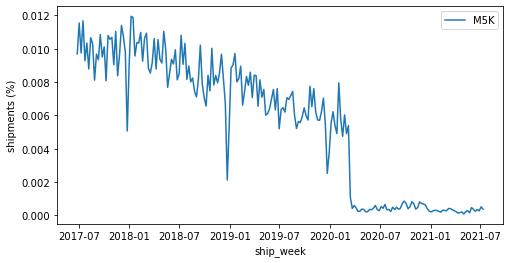

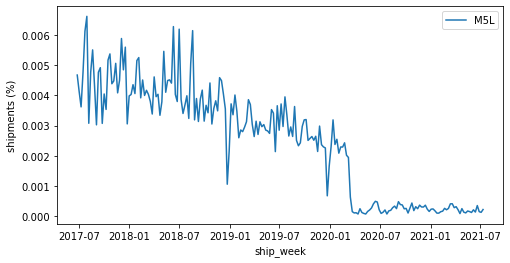

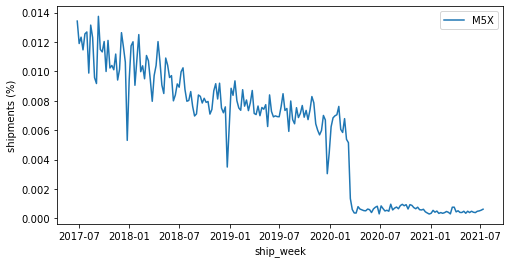

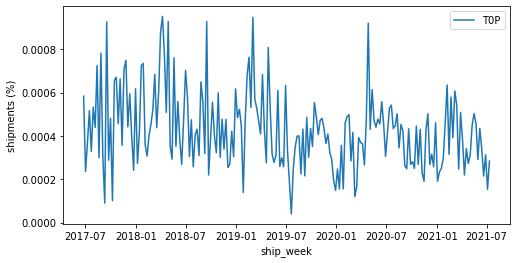

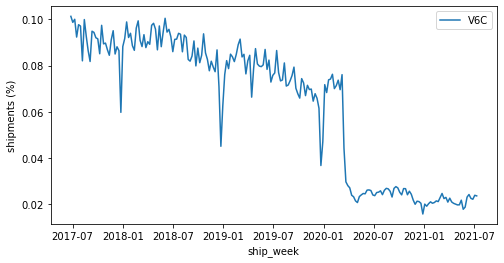

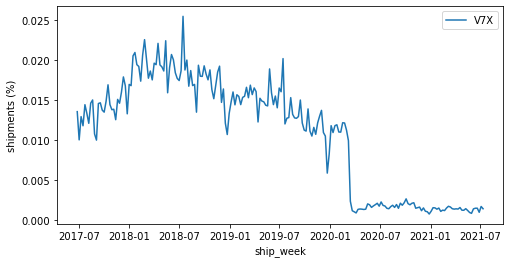

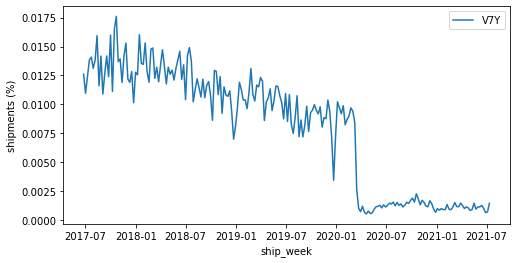

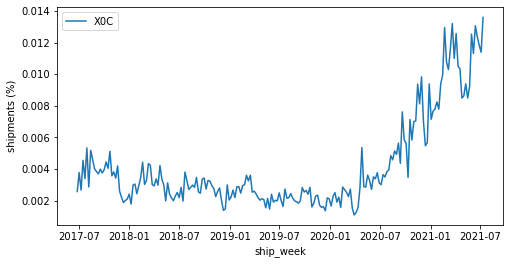

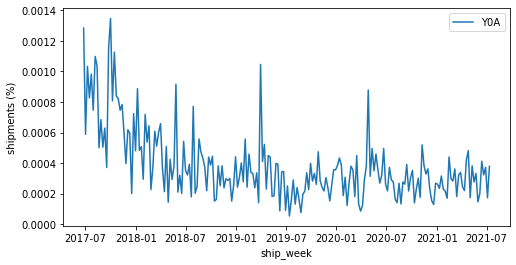

In [42]:
# multiplied by 100

for key, grp in viz_pct_20.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('shipments (%)')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()

## Proportion Visuals for all the eight FSA

In [43]:
#pct_data1[pct_data1['ship_week']=='2017-05-28']
#viz_pct = pct_data1[(pct_data1['ship_week']=='2017-05-28','2018-05-28') & 
                    #(pct_data1['zipcode'].isin(['A0A', 'A0B', 'A0C', 'A0E']))]
    
    
viz_pct = pct_data1[(pct_data1['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
viz_pct

ship_week zipcode      pkgs
338    2017-06-25     G7Z  0.002335
345    2017-06-25     G8J  0.004087
365    2017-06-25     H0M  0.000350
408    2017-06-25     H3C  0.099012
651    2017-06-25     K0K  0.277419
...           ...     ...       ...
347394 2021-07-11     H3C  0.087050
347638 2021-07-11     K0K  0.376742
347981 2021-07-11     N0B  0.285336
348163 2021-07-11     R0K  0.038847
348514 2021-07-11     V4B  0.055704

[1687 rows x 3 columns]

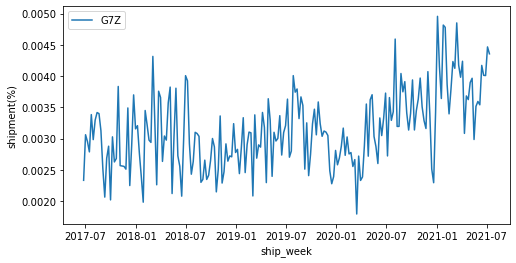

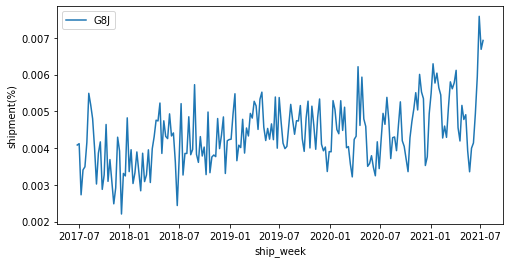

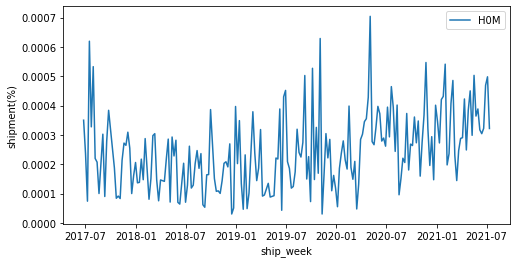

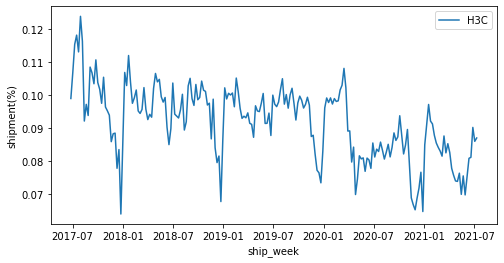

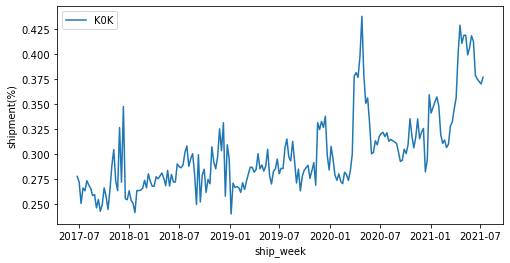

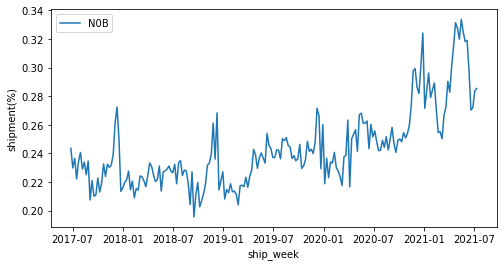

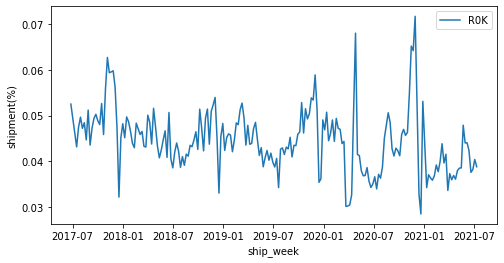

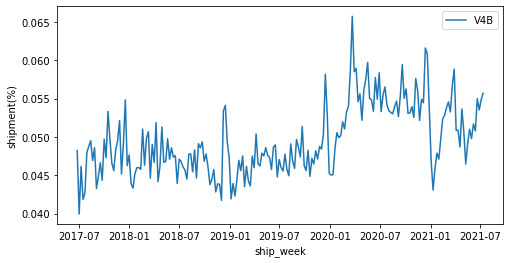

In [45]:
#multiplied by 100
#fig, ax = plt.subplots(figsize=(10,4))
for key, grp in viz_pct.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('shipment(%)')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()
    #plt.close()

## Package distribution 

In [55]:
pkg_num = mod_df[(mod_df['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pkg_num

zipcode   pkgs
ship_week                
2017-06-25     G7Z     20
2017-06-25     G8J     35
2017-06-25     H0M      3
2017-06-25     H3C    848
2017-06-25     K0K   2376
...            ...    ...
2021-07-11     H3C   4596
2021-07-11     K0K  19891
2021-07-11     N0B  15065
2021-07-11     R0K   2051
2021-07-11     V4B   2941

[1687 rows x 2 columns]

In [57]:
pkg_num_rst = pkg_num.reset_index()

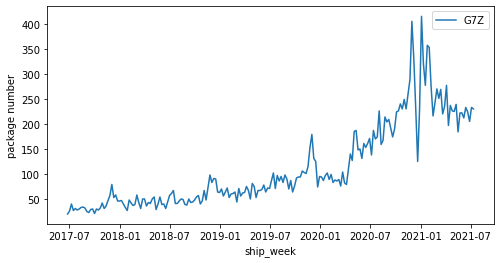

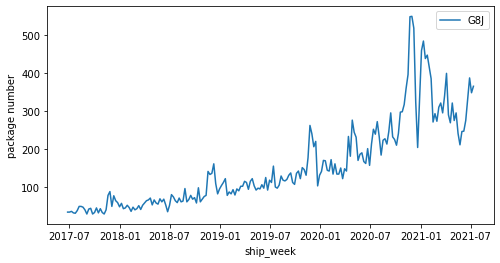

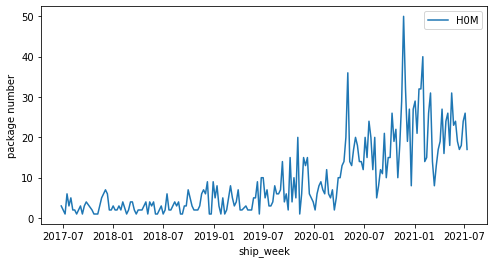

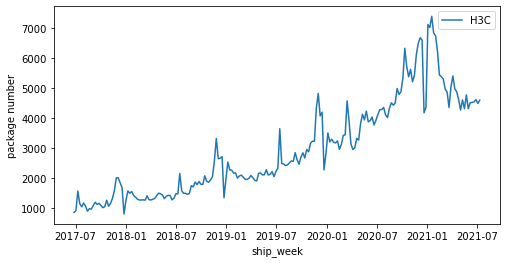

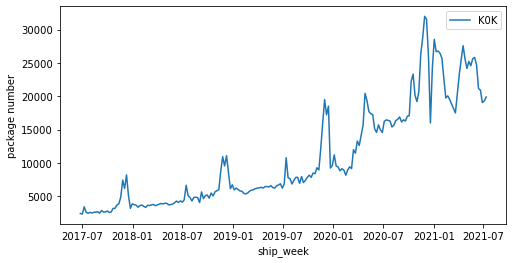

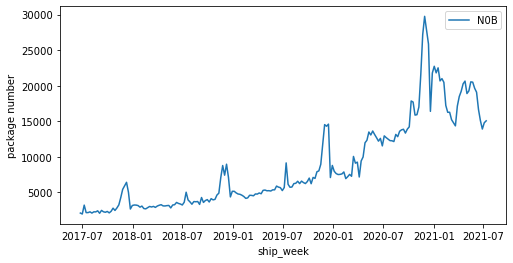

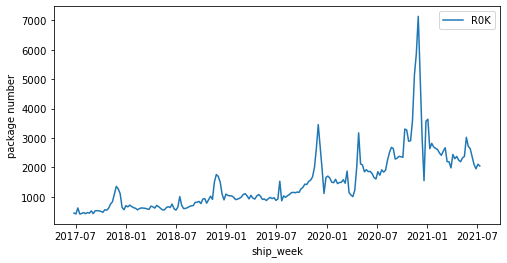

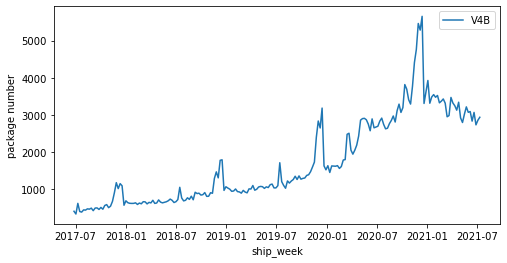

In [59]:
for key, grp in pkg_num_rst.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('package number')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()

In [48]:
df= mod_df.groupby(['zipcode'], sort=False)
df.head()

zipcode  pkgs
ship_week               
2017-06-11     A0A   363
2017-06-11     A0B   179
2017-06-11     A0C   103
2017-06-11     A0E   221
2017-06-11     A0G   347
...            ...   ...
2019-09-08     R5P    21
2019-09-08     R5R    33
2019-09-15     S7A     1
2019-09-22     S7A     1
2019-10-20     V7Z     1

[8260 rows x 2 columns]

In [15]:
#avg of number of packages/postal codes 
FSA_df= mod_df.groupby(['zipcode'], sort=False).mean()
FSA_df.head()

pkgs
zipcode             
A0A      1417.117925
A0B       737.202830
A0C       382.410377
A0E       735.660377
A0G      1344.122642

In [16]:
#postalcodes that have < 7 shippment/week on the average
FSA_df[FSA_df['pkgs'] < 7]

pkgs
zipcode          
X0G      4.676617
T0V      3.994681

In [23]:
#zipcodes placed in percentiles 
df_pct = pd.cut(FSA_df.pkgs, np.percentile(FSA_df.pkgs, [0, 1, 5, 25, 50, 75, 95, 99, 100]),
                  include_lowest=True)
df_pct

zipcode
A0A    (675.002, 1529.764]
A0B    (675.002, 1529.764]
A0C     (121.339, 675.002]
A0E    (675.002, 1529.764]
A0G    (675.002, 1529.764]
              ...         
R5L     (121.339, 675.002]
R5N     (121.339, 675.002]
R5T      (29.486, 121.339]
R5P      (29.486, 121.339]
R5R     (121.339, 675.002]
Name: pkgs, Length: 1652, dtype: category
Categories (8, interval[float64]): [(3.994, 29.486] < (29.486, 121.339] < (121.339, 675.002] < (675.002, 1529.764] < (1529.764, 2797.087] < (2797.087, 5399.393] < (5399.393, 9431.656] < (9431.656, 16133.156]]

In [24]:
df_pct1 = df_pct.cat.rename_categories([1, 5, 25, 50, 75, 95, 99, 100])
df_pct1

zipcode
A0A    50
A0B    50
A0C    25
A0E    50
A0G    50
       ..
R5L    25
R5N    25
R5T     5
R5P     5
R5R    25
Name: pkgs, Length: 1652, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [41]:
df_pct2 = df_pct1.groupby('zipcode').nunique()  #find out what to do here 

In [31]:
df_pct3 = df_pct1.groupby(df_pct1).sample(n=1, random_state=1)
df_pct3

zipcode
H0M      1
G7Z      5
G8J     25
R0K     50
V4B     75
H3C     95
N0B     99
K0K    100
Name: pkgs, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [34]:
df_pct3 = df_pct1.groupby(df_pct1).sample(n=1)
df_pct3

zipcode
T6Y      1
V7Z      5
B3R     25
P3L     50
L1A     75
N1G     95
V4N     99
M2N    100
Name: pkgs, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [62]:
sql = """

WITH pka_dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
      AND shipping_address_country_code = 'CA'
      AND ship_week < '2021-05-02'
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, GETDATE())))))
      AND marketplace_id=7
    UNION
     SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_date)))) AS ship_week
    ,SUBSTRING(destination_postal_code,1,3) AS zipcode
    ,fulfillment_shipment_id AS OTM_OBCUST_PKG_REC_ID
    ,originating_fulfillment_center AS warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM perfectmile_ext.d_perfectmile_pkg_attributes_v2_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(originating_fulfillment_center) NOT IN ('PTOP')
      AND destination_country_code = 'CA'
      AND ship_week < trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, GETDATE()))))
      AND ship_week >= '2021-05-02'
      AND marketplace_id=7
    )


SELECT ship_week
    ,pka_dosp.zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
FROM pka_dosp
    INNER JOIN trans_dims_ddl.warehouses w
    ON pka_dosp.warehouse_id = w.warehouse_id
    AND w.legal_entity_id = 115
    AND w.is_sortcenter = 'N'                                           
    AND w.is_prime_now = 'N'                                            
    AND w.is_fresh = 'N'
    and zipcode in ('H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K')
GROUP BY 1,
         2
ORDER BY 1,2;
    
    """


In [63]:
eigt_FSA =pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
eigt_FSA

zipcode   pkgs
ship_week                
2017-07-09     G7Z     40
2017-07-09     G8J     37
2017-07-09     H0M      1
2017-07-09     H3C   1563
2017-07-09     K0K   3389
...            ...    ...
2021-07-25     H3C   4389
2021-07-25     K0K  19548
2021-07-25     N0B  15390
2021-07-25     R0K   1765
2021-07-25     V4B   2911

[1687 rows x 2 columns]

In [64]:
mod_8 = mod_df[(mod_df['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
mod_8

zipcode   pkgs
ship_week                
2017-07-09     G7Z     40
2017-07-09     G8J     37
2017-07-09     H0M      1
2017-07-09     H3C   1563
2017-07-09     K0K   3389
...            ...    ...
2021-07-25     H3C   4389
2021-07-25     K0K  19548
2021-07-25     N0B  15390
2021-07-25     R0K   1765
2021-07-25     V4B   2911

[1687 rows x 2 columns]

In [65]:
#% volume distribution/week/FSA..for all FSAs
pct = eigt_FSA.groupby(['ship_week','zipcode']).sum()/eigt_FSA.groupby(['ship_week']).sum()*100
pct.head()

pkgs
ship_week  zipcode           
2017-07-09 G7Z       0.421896
           G8J       0.390254
           H0M       0.010547
           H3C      16.485603
           K0K      35.745175

In [15]:
#% volume distribution/week/FSA
#pct1 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()*100
#pct1.head()

In [18]:
#pct_data1 = pct1.reset_index()
#pct_data1.head()

In [19]:
#for key, grp in pct_data.groupby(['zipcode']):
    #fig, ax = plt.subplots(figsize=(10,4))
    #plt.plot( grp['pkgs'], label=key)
    #plt.legend()
    #plt.show()
    #plt.close()

In [17]:
pct.loc[pd.to_datetime('2021-06-13')].pkgs.sum()

100.0

In [ ]:
#data_pred = pred.to_frame()
#data_pred1 = data_pred.reset_index()
#data_pred1.columns =['ship_week', 'pkgs_num']
#data_pred1.head(10)

In [66]:
pct_data = pct.reset_index()
pct_data.head()

ship_week zipcode       pkgs
0 2017-07-09     G7Z   0.421896
1 2017-07-09     G8J   0.390254
2 2017-07-09     H0M   0.010547
3 2017-07-09     H3C  16.485603
4 2017-07-09     K0K  35.745175

In [97]:
#fig, ax = plt.subplots(figsize=(10,4))
#for key, grp in pct_data.groupby(['zipcode']):
    #fig, ax = plt.subplots(figsize=(10,4))
    #plt.plot(grp[''] grp['pkgs'], label=key)
    #plt.legend()
    #plt.show()
    #plt.close()

In [57]:
#import multiprocessing
#multiprocessing.cpu_count().....8

In [67]:
#avg of number of packages/postal codes 
new_FSA= eigt_FSA.groupby(['zipcode'], sort=False).mean()
new_FSA

pkgs
zipcode              
G7Z        113.655660
G8J        156.816038
H0M          9.798030
H3C       2968.570755
K0K      10853.084906
N0B       8756.452830
R0K       1496.136792
V4B       1744.500000

array([[<AxesSubplot:title={'center':'pkgs'}>]], dtype=object)

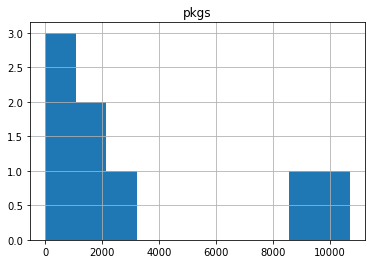

In [29]:
#avg of number of packages/postal codes 
new_FSA= eigt_FSA.groupby(['zipcode'], sort=False).mean()
new_FSA.head(10).hist()

In [30]:
FSA_sum= eigt_FSA.groupby(['zipcode'], sort=False).sum()
FSA_sum

pkgs
zipcode         
G7Z        23676
G8J        32729
H0M         1938
H3C       621892
K0K      2266007
N0B      1830497
R0K       313905
V4B       364635

## Absolute Visuals

In [28]:
# sea_grp = eigt_FSA.groupby('zipcode')
# for key in sea_grp.groups.keys():
#     sea_grp.get_group(key).plot(title=key)

## R0K Postalcode for analysis

In [68]:
#extract R0K data for analysis
post_code = eigt_FSA[eigt_FSA.zipcode == 'R0K']
post_code

zipcode  pkgs
ship_week               
2017-07-09     R0K   624
2017-07-16     R0K   418
2017-07-23     R0K   435
2017-07-30     R0K   466
2017-08-06     R0K   430
...            ...   ...
2021-06-27     R0K  1955
2021-07-04     R0K  2109
2021-07-11     R0K  2051
2021-07-18     R0K  2262
2021-07-25     R0K  1765

[212 rows x 2 columns]

In [69]:
m_code = post_code.reset_index()
m_code

ship_week zipcode  pkgs
0   2017-07-09     R0K   624
1   2017-07-16     R0K   418
2   2017-07-23     R0K   435
3   2017-07-30     R0K   466
4   2017-08-06     R0K   430
..         ...     ...   ...
207 2021-06-27     R0K  1955
208 2021-07-04     R0K  2109
209 2021-07-11     R0K  2051
210 2021-07-18     R0K  2262
211 2021-07-25     R0K  1765

[212 rows x 3 columns]

In [11]:
m_code[m_code['ship_week']=='2020-06-21']

ship_week zipcode  pkgs
157 2020-06-21     R0K  1660

In [204]:
post_code.reset_index().ship_week.min()

Timestamp('2017-06-11 00:00:00')

In [205]:
post_code.reset_index().ship_week.max()

Timestamp('2021-06-27 00:00:00')

In [209]:
len(post_code.reset_index().ship_week.unique())

212

## Split data

In [17]:
#split data: Train (3 years; 160weeks), Test (1 year; 52weeks),and Forecast (3 years; 325weeks)

train_data = post_code[-4*212:160]
test_data = post_code[-52:]
fcst_data = post_code[-3*52:]

In [18]:
fcst_data = post_code[-3*52:]
fcst_data

zipcode  pkgs
ship_week               
2018-08-05     R0K   609
2018-08-12     R0K   635
2018-08-19     R0K   671
2018-08-26     R0K   697
2018-09-02     R0K   704
...            ...   ...
2021-06-27     R0K  1955
2021-07-04     R0K  2109
2021-07-11     R0K  2051
2021-07-18     R0K  2262
2021-07-25     R0K  1765

[156 rows x 2 columns]

In [25]:
train_data = post_code[-4*212:160]
train_data

zipcode  pkgs
ship_week               
2017-07-09     R0K   624
2017-07-16     R0K   418
2017-07-23     R0K   435
2017-07-30     R0K   466
2017-08-06     R0K   430
...            ...   ...
2020-06-28     R0K  1607
2020-07-05     R0K  1856
2020-07-12     R0K  1738
2020-07-19     R0K  1919
2020-07-26     R0K  1843

[160 rows x 2 columns]

In [14]:
train_data.shape

(160, 2)

In [17]:
type(train_data)

pandas.core.frame.DataFrame

In [53]:
test_data = post_code[-52:]
#test_data

In [18]:
type(test_data)

pandas.core.frame.DataFrame

## Dipslay the MIN and MAX of the divided datasets 

In [360]:
m = train_data.reset_index()
m.ship_week.min()

Timestamp('2017-06-11 00:00:00')

In [361]:
m.ship_week.max()

Timestamp('2020-06-28 00:00:00')

In [224]:
m[m['ship_week']=='2020-06-21']

Empty DataFrame
Columns: [ship_week, zipcode, pkgs]
Index: []

In [196]:
m1 = test_data.reset_index()
m1.ship_week.min()

Timestamp('2020-07-05 00:00:00')

In [197]:
m1.ship_week.max()

Timestamp('2021-06-27 00:00:00')

In [160]:
m2 = fcst_data.reset_index()
m2.ship_week.min()

Timestamp('2018-07-08 00:00:00')

In [161]:
m2.ship_week.max()

Timestamp('2021-06-27 00:00:00')

## Visualize training and testing 

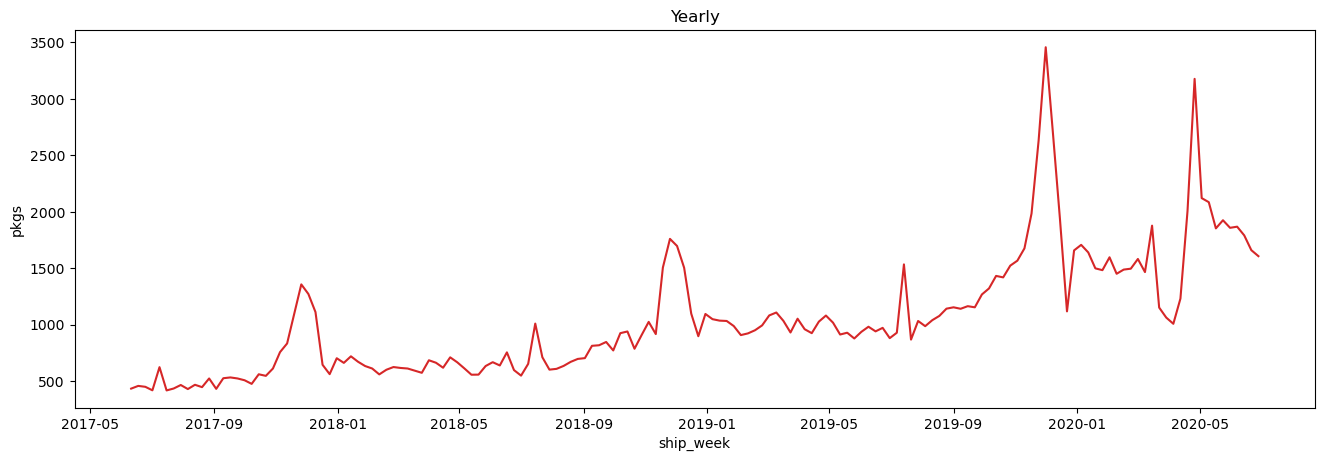

In [16]:
#train data visuals

def plot_train_data(train_data, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    #q.groupby('zipcode')['pkgs'].plot(legend=True)
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_train_data(train_data, x=train_data.index, y=train_data.pkgs, title='Yearly')    


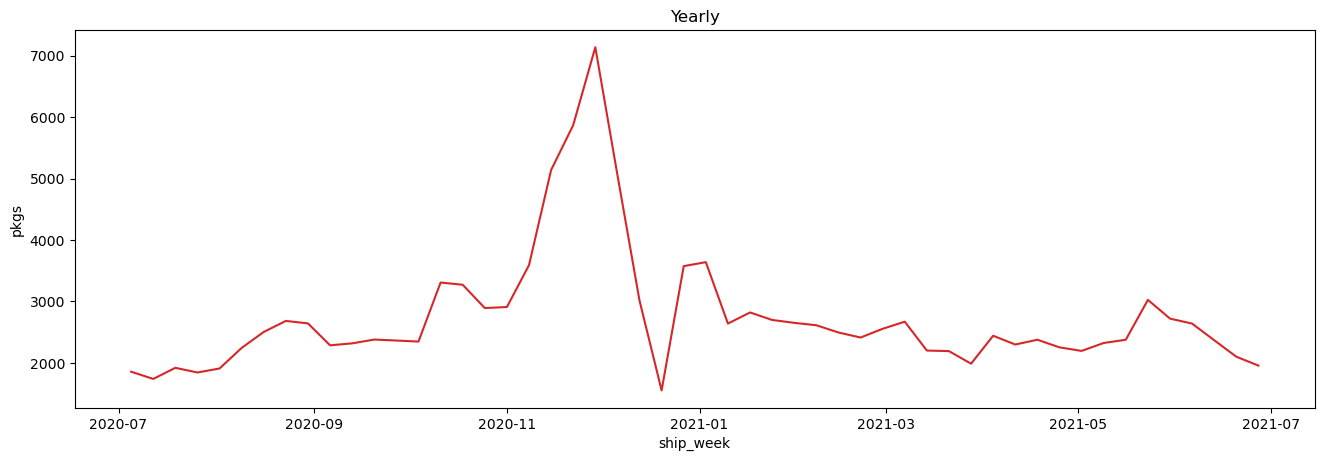

In [17]:
#visualize test data to check the similarity

def plot_test_data(test_data, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    #q.groupby('zipcode')['pkgs'].plot(legend=True)
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_test_data(test_data, x=test_data.index, y=test_data.pkgs, title='Yearly')

## Fitting Model 

## Moving Average

In [20]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA 


In [21]:
#train
train_data = post_code[-4*212:160]

#test
test_data = post_code[-52:]

#forecast
fcst_data = post_code[-3*52:]

In [22]:
#train
train_data = post_code[-4*212:160]

In [26]:
train_data1 = train_data.iloc[:,1]
train_data1

ship_week
2017-07-09     624
2017-07-16     418
2017-07-23     435
2017-07-30     466
2017-08-06     430
              ... 
2020-06-28    1607
2020-07-05    1856
2020-07-12    1738
2020-07-19    1919
2020-07-26    1843
Name: pkgs, Length: 160, dtype: int64

In [24]:
test_data = post_code[-52:]
test_data1 = test_data.iloc[:,1]
test_data1

ship_week
2020-08-02    1908
2020-08-09    2243
2020-08-16    2503
2020-08-23    2682
2020-08-30    2642
2020-09-06    2285
2020-09-13    2317
2020-09-20    2379
2020-09-27    2363
2020-10-04    2346
2020-10-11    3307
2020-10-18    3271
2020-10-25    2892
2020-11-01    2908
2020-11-08    3590
2020-11-15    5138
2020-11-22    5869
2020-11-29    7137
2020-12-06    5060
2020-12-13    3013
2020-12-20    1551
2020-12-27    3574
2021-01-03    3639
2021-01-10    2639
2021-01-17    2820
2021-01-24    2698
2021-01-31    2651
2021-02-07    2612
2021-02-14    2494
2021-02-21    2412
2021-02-28    2554
2021-03-07    2670
2021-03-14    2200
2021-03-21    2191
2021-03-28    1986
2021-04-04    2441
2021-04-11    2298
2021-04-18    2376
2021-04-25    2252
2021-05-02    2194
2021-05-09    2323
2021-05-16    2376
2021-05-23    3025
2021-05-30    2720
2021-06-06    2639
2021-06-13    2368
2021-06-20    2100
2021-06-27    1955
2021-07-04    2109
2021-07-11    2051
2021-07-18    2262
2021-07-25    1765
Na

## Transformed data modelling 

In [15]:
#train_data_diff = train_data1.diff()
# train_data_diff = train_data1.diff().fillna(train_data1)
# pyplot.plot(train_data_diff)
# plt.show()

In [105]:
train_data_diff

ship_week
2017-06-11    434.0
2017-06-18     24.0
2017-06-25     -8.0
2017-07-02    -31.0
2017-07-09    205.0
              ...  
2020-05-31    -67.0
2020-06-07     10.0
2020-06-14    -77.0
2020-06-21   -131.0
2020-06-28    -53.0
Name: pkgs, Length: 160, dtype: float64

In [16]:
# train_data_diff2 = train_data_diff.diff().fillna(train_data_diff)
# pyplot.plot(train_data_diff2)
# plt.show()

In [108]:
train_data_diff2

ship_week
2017-06-11    434.0
2017-06-18   -410.0
2017-06-25    -32.0
2017-07-02    -23.0
2017-07-09    236.0
              ...  
2020-05-31   -139.0
2020-06-07     77.0
2020-06-14    -87.0
2020-06-21    -54.0
2020-06-28     78.0
Name: pkgs, Length: 160, dtype: float64

In [17]:
# train_data_diff3 = train_data_diff2.diff().fillna(train_data_diff2)
# pyplot.plot(train_data_diff3)
# plt.show()

In [110]:
train_data_diff3

ship_week
2017-06-11    434.0
2017-06-18   -844.0
2017-06-25    378.0
2017-07-02      9.0
2017-07-09    259.0
              ...  
2020-05-31   -443.0
2020-06-07    216.0
2020-06-14   -164.0
2020-06-21     33.0
2020-06-28    132.0
Name: pkgs, Length: 160, dtype: float64

In [18]:
# plot_acf(train_data_diff2, lags=20)

In [19]:
# plot_pacf(train_data_diff2, lags=20)

## Fit the MA model 

In [60]:
#AR(0) & MA(1).
model = ARIMA(train_data1, order=(1,1,3))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  160
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1094.143
Date:                Wed, 21 Jul 2021   AIC                           2198.285
Time:                        11:32:50   BIC                           2213.630
Sample:                    06-25-2017   HQIC                          2204.516
                         - 07-12-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3681      0.207      1.782      0.075      -0.037       0.773
ma.L1         -0.4591      0.213     -2.154      0.031      -0.877      -0.041
ma.L2         -0.1366      0.084     -1.625      0.104      -0.301       0.028
ma.L3         -0.2277      0.126     -1.804      0.071      -0.475       0.020
sigma2      5.532e+04   2989.293     18.507      0.000    4.95e+04    6.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               391.88
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              11.38   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
#prediction on the test data
#test_data1 = test_data.iloc[:,1]
pred_model = model_fit.predict(start=160, end=160+52-1)
pred_model

2020-07-19    1747.479549
2020-07-26    1723.110631
2020-08-02    1748.049488
2020-08-09    1757.230724
2020-08-16    1760.610795
2020-08-23    1761.855167
2020-08-30    1762.313283
2020-09-06    1762.481938
2020-09-13    1762.544028
2020-09-20    1762.566887
2020-09-27    1762.575302
2020-10-04    1762.578400
2020-10-11    1762.579541
2020-10-18    1762.579961
2020-10-25    1762.580115
2020-11-01    1762.580172
2020-11-08    1762.580193
2020-11-15    1762.580201
2020-11-22    1762.580204
2020-11-29    1762.580205
2020-12-06    1762.580205
2020-12-13    1762.580205
2020-12-20    1762.580205
2020-12-27    1762.580205
2021-01-03    1762.580205
2021-01-10    1762.580205
2021-01-17    1762.580205
2021-01-24    1762.580205
2021-01-31    1762.580205
2021-02-07    1762.580205
2021-02-14    1762.580205
2021-02-21    1762.580205
2021-02-28    1762.580205
2021-03-07    1762.580205
2021-03-14    1762.580205
2021-03-21    1762.580205
2021-03-28    1762.580205
2021-04-04    1762.580205
2021-04-11  

In [52]:
pred_model.tail(10)

2021-05-09    1762.580205
2021-05-16    1762.580205
2021-05-23    1762.580205
2021-05-30    1762.580205
2021-06-06    1762.580205
2021-06-13    1762.580205
2021-06-20    1762.580205
2021-06-27    1762.580205
2021-07-04    1762.580205
2021-07-11    1762.580205
Freq: W-SUN, Name: predicted_mean, dtype: float64

## Forecast

In [62]:
#forecast
fcst_data = post_code[-3*52:]
fcst = fcst_data.iloc[:,1]
fcst

ship_week
2018-07-22     712
2018-07-29     602
2018-08-05     609
2018-08-12     635
2018-08-19     671
              ... 
2021-06-13    2368
2021-06-20    2100
2021-06-27    1955
2021-07-04    2109
2021-07-11    2051
Name: pkgs, Length: 156, dtype: int64

In [54]:
fct_model = ARIMA(fcst, order=(1,1,3))
fct_fit = fct_model.fit()
fct_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  156
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1155.195
Date:                Mon, 19 Jul 2021   AIC                           2320.390
Time:                        13:55:12   BIC                           2335.607
Sample:                    07-22-2018   HQIC                          2326.571
                         - 07-11-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0640      0.105      0.610      0.542      -0.142       0.270
ma.L1          0.0209      0.115      0.183      0.855      -0.204       0.245
ma.L2         -0.2331      0.043     -5.381      0.000      -0.318      -0.148
ma.L3         -0.3831      0.065     -5.886      0.000      -0.511      -0.256
sigma2      1.735e+05   1.23e+04     14.097      0.000    1.49e+05    1.98e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               123.74
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               9.55   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
#forecast on the training data
forecast = fct_fit.predict(start=160, end=160+352-1)
forecast

2021-08-15    2159.087590
2021-08-22    2159.123597
2021-08-29    2159.125902
2021-09-05    2159.126050
2021-09-12    2159.126059
                 ...     
2028-04-09    2159.126060
2028-04-16    2159.126060
2028-04-23    2159.126060
2028-04-30    2159.126060
2028-05-07    2159.126060
Freq: W-SUN, Name: predicted_mean, Length: 352, dtype: float64

In [56]:
forecast.tail(10)

2028-03-05    2159.12606
2028-03-12    2159.12606
2028-03-19    2159.12606
2028-03-26    2159.12606
2028-04-02    2159.12606
2028-04-09    2159.12606
2028-04-16    2159.12606
2028-04-23    2159.12606
2028-04-30    2159.12606
2028-05-07    2159.12606
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [35]:
# data_fct = forecast.to_frame()
# data_fct = data_fct.reset_index()
# data_fct.columns =['ship_week', 'pkgs']
# data_fct.head()

In [26]:
#extract R0K data for analysis
# post_code = eigt_FSA[eigt_FSA.zipcode == 'R0K']
# post_code.head()

In [27]:
# post_rok = post_code.reset_index()
# post_rok.head()

In [28]:
# def mean_absolute_percentage_error(post_rok, data_fct): 
#     post_rok, data_fct = np.array(post_rok['pkgs']), np.array(data_fct['pkgs'])
#     return np.mean(np.abs((post_rok['pkgs'] - data_fct['pkgs']) / y_true['pkgs'])) * 100

In [29]:
# mean_absolute_percentage_error(post_rok, data_fct)

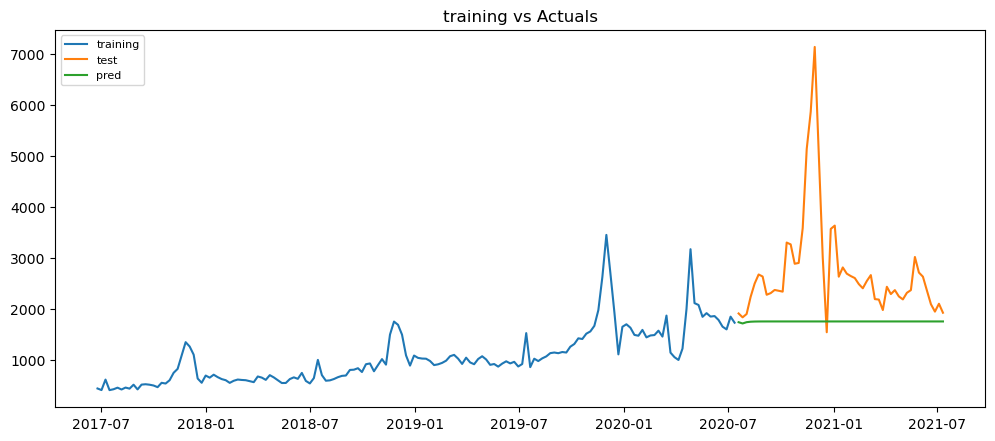

In [57]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(test_data1, label='test')
plt.plot(pred_model, label='pred')
plt.title('training vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

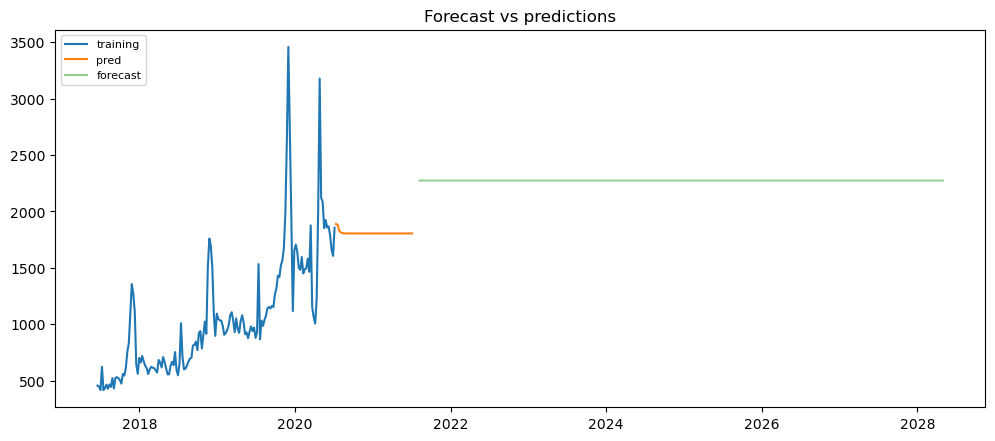

In [36]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(pred_model, label='pred')
plt.plot(forecast, label='forecast', alpha=.5)
#plt.plot(data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['ship_week'], data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['pkgs_num'],
#label ='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Without Differencing 

In [40]:
# #without differencing or transformation 
# model1 = ARIMA(train_data1, order=(1,0,3))
# model_fit1 = model1.fit()
# model_fit1.summary()

In [41]:
#prediction on the test data
# pred_model1 = model_fit1.predict(start=156, end=156+52-1)
# pred_model1.head(10)

## forecasts 

In [42]:
# #forecast
# fcst_data1 = post_code[-3*52:]
# fcst1 = fcst_data1.iloc[:,1]
# fcst1

In [43]:
# model_fct = ARIMA(fcst1, order=(1,0,3))
# model_fct1 = model_fct.fit()
# model_fct1.summary()

In [44]:
# #forecast on the training data
# forecast1 = model_fct1.predict(start=156, end=156+352-1)
# forecast1.head(10)

## Seasonal ARIMA Model

In [27]:
#train
train_data = post_code[-4*212:160]
train_data2 = train_data.iloc[:,1]
train_data2

ship_week
2017-07-09     624
2017-07-16     418
2017-07-23     435
2017-07-30     466
2017-08-06     430
              ... 
2020-06-28    1607
2020-07-05    1856
2020-07-12    1738
2020-07-19    1919
2020-07-26    1843
Name: pkgs, Length: 160, dtype: int64

In [70]:
#plot_pacf(train_data2, lags=20)

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools 
import pmdarima as pm

In [50]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=52,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=1493.871, Time=4.51 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1552.084, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1491.893, Time=1.40 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1513.842, Time=6.24 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1675.417, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1489.894, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=1491.894, Time=1.32 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=1493.889, Time=3.57 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=1491.832, Time=0.75 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1491.901, Time=0.37 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1512.017, Time=0.92 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=1493.843, Time=0.57 sec
 ARIMA(1,0,0)(0,1,0)[52]             : AIC=1502.140, Time=0.29 sec

Best model:  ARIMA(1,0,0)(0,1,0)[52] intercept
Total fit time: 20.517 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  160
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -741.947
Date:                            Thu, 08 Jul 2021   AIC                           1489.894
Time:                                    13:34:38   BIC                           1497.940
Sample:                                         0   HQIC                          1493.156
                                            - 160                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    156.1981     47.936      3.258      0.001      62.245     250.152
ar.L1          0.6654      0.057     11.628      0.000       0.553       0.778
sigma2      5.406e+04   4022.232     13.439      0.000    4.62e+04    6.19e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               616.82
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               6.81   Skew:                             2.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## US Forecast Parameters

In [59]:
best_model = SARIMAX(train_data2, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                pkgs   No. Observations:                  160
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -738.140
Date:                             Mon, 19 Jul 2021   AIC                           1482.280
Time:                                     13:56:08   BIC                           1490.298
Sample:                                 06-25-2017   HQIC                          1485.530
                                      - 07-12-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5338      0.101      5.282      0.000       0.336       0.732
ma.L1         -0.9386      

## Generated Parameters

In [110]:
#best_model1 = SARIMAX(train_data2, order=(1, 0, 0), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
#print(best_model1.summary())

## Predictions and Forecasting 

In [60]:
pred = best_model.predict(start=160, end=160+52-1)
pred.head(10)

2020-07-19    1290.826092
2020-07-26    1572.628132
2020-08-02    1588.973149
2020-08-09    1675.250831
2020-08-16    1731.013344
2020-08-23    1804.494378
2020-08-30    1821.555037
2020-09-06    1811.256247
2020-09-13    1835.698062
2020-09-20    1826.467655
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [61]:
pred.tail(10)

2021-05-09    2758.348722
2021-05-16    2526.348722
2021-05-23    2598.348722
2021-05-30    2531.348722
2021-06-06    2541.348722
2021-06-13    2464.348722
2021-06-20    2333.348722
2021-06-27    2280.348722
2021-07-04    2529.348722
2021-07-11    2411.348722
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [74]:
#data_pred = pred.to_frame()
#data_pred1 = data_pred.reset_index()
#data_pred1.columns =['ship_week', 'pkgs_num']
#data_pred1.head(10)

## forecasts

In [28]:
#forecast
fcst_data2 = post_code[-3*52:]
fcst2 = fcst_data2.iloc[:,1]
fcst2

ship_week
2018-07-22     712
2018-07-29     602
2018-08-05     609
2018-08-12     635
2018-08-19     671
              ... 
2021-06-13    2368
2021-06-20    2100
2021-06-27    1955
2021-07-04    2109
2021-07-11    2051
Name: pkgs, Length: 156, dtype: int64

In [63]:
best_model_fct = SARIMAX(fcst2, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
print(best_model_fct.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                pkgs   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -774.923
Date:                             Mon, 19 Jul 2021   AIC                           1555.846
Time:                                     13:56:30   BIC                           1563.750
Sample:                                 07-22-2018   HQIC                          1559.047
                                      - 07-11-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6318      0.082      7.667      0.000       0.470       0.793
ma.L1         -0.8996      

In [64]:
fct = best_model_fct.predict(start=160, end=160+352-1)
fct.head(10)

2021-08-15    2994.717915
2021-08-22    3185.946044
2021-08-29    3153.671562
2021-09-05    2801.552408
2021-09-12    2836.636041
2021-09-19    2900.584227
2021-09-26    2885.815056
2021-10-03    2869.592672
2021-10-10    3831.083957
2021-10-17    3795.394342
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [65]:
fct.tail(10)

2028-03-05    5874.488235
2028-03-12    5865.488248
2028-03-19    5660.488256
2028-03-26    6115.488261
2028-04-02    5972.488264
2028-04-09    6050.488266
2028-04-16    5926.488267
2028-04-23    5868.488268
2028-04-30    5997.488269
2028-05-07    6050.488269
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [73]:
#data_fct = fct.to_frame()
#data_fct1 = data_fct.reset_index()
#data_fct1.columns =['ship_week', 'pkgs_num']
#data_fct1.head(10)

In [78]:
#for_v_act= pd.merge(data_fct1,  data_pred1, on=['ship_week'], 
                    #how='inner', suffixes= ('_fct', '_act'))
#for_v_act.head()

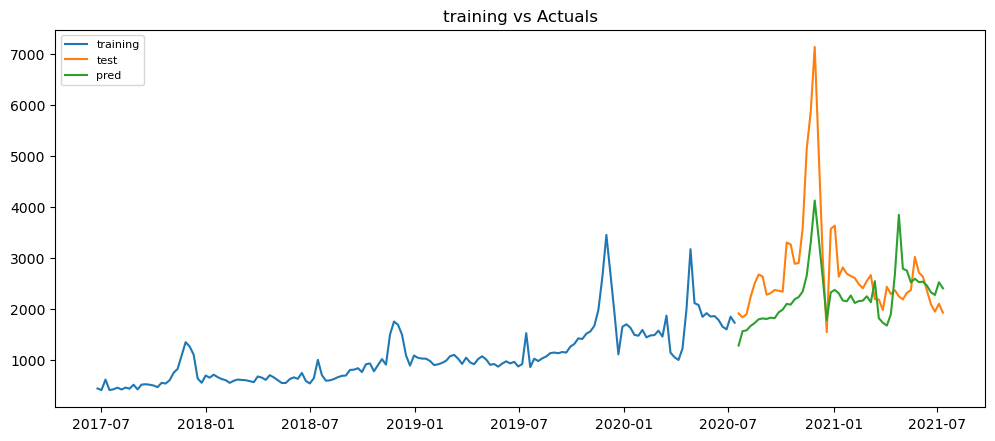

In [66]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(test_data1, label='test')
plt.plot(pred, label='pred')
plt.title('training vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

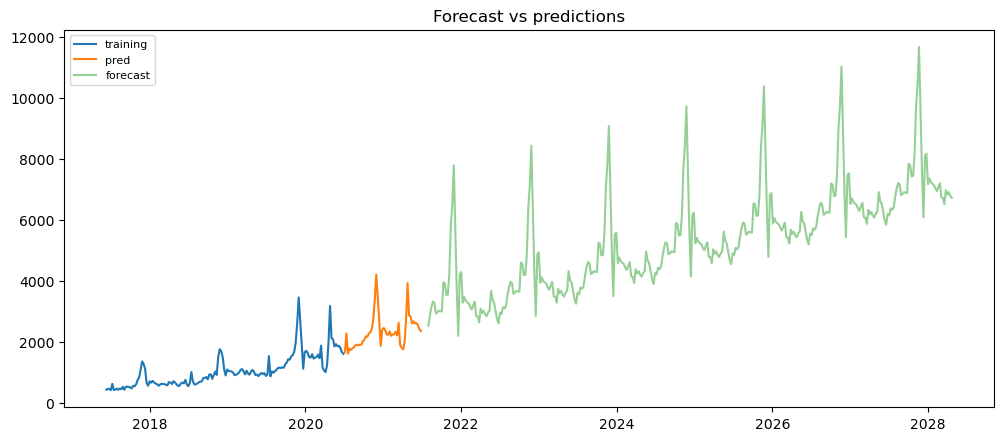

In [66]:
# Plot forecast vs actuals 
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(pred, label='pred')
plt.plot(fct, label='forecast', alpha=.5)
#plt.plot(data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['ship_week'], data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['pkgs_num'],
#label ='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Multiprocessing 

In [38]:
# mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
# mod_df

In [29]:
#import modules 
import multiprocessing as mp
from itertools import zip_longest
import time
#from numpy.linalg import LinAlgError

## V1 Version 

In [30]:
# define function 
def run_V1_models(df):
    
    #input from the model 
    
    #df = df.set_index('ship_week')
    train_data = df[-4*212:160]
    test_data = df[-52:]
    fcst_data = df[-3*52:]
    
    
    train_data1 = train_data.iloc[:,1]
    test_data1 = test_data.iloc[:,1]
    fcst = fcst_data.iloc[:,1]
   
    
    #model fit 
    model = ARIMA(train_data1, order=(1,1,3))
    model_fit = model.fit()
    
    
    #predict model
    pred_model = model_fit.predict(start=160, end=160+52-1)
    pred_model = pd.DataFrame(pred_model)
    pred_model.columns= ['pred']
    pred_model['zipcode'] = df['zipcode'].unique()[0]
    
    
    #forecast model
    fct_model = ARIMA(fcst, order=(1,1,3))  
    fct_fit = fct_model.fit()
    
    
    forecast = fct_fit.predict(start=160, end=160+352-1)
    forecast = pd.DataFrame(forecast) 
    forecast.columns = ['pred']
    forecast['zipcode'] = df['zipcode'].unique()[0]
    
    
    
    return pred_model, forecast

#mod = sm.tsa.SARIMAX(y, order=(0 1,0), seasonal_order=(1,0,0,12),enforce_stationarity=False)
#initialization='approximate_diffuse'

In [70]:
#extract R0K from the fxn 
result = run_V1_models(mod_df[mod_df['zipcode']=='R0K'])
#result

## multprocessing on 8 FSA

In [71]:
eigt_FSA =pd.read_sql (sql, con=con, parse_dates=['ship_week']) #index_col='ship_week')
eigt_FSA

ship_week zipcode   pkgs
0    2017-06-11     G7Z     30
1    2017-06-11     G8J     33
2    2017-06-11     H0M      1
3    2017-06-11     H3C    846
4    2017-06-11     K0K   2331
...         ...     ...    ...
1682 2021-06-27     H3C   4615
1683 2021-06-27     K0K  19044
1684 2021-06-27     N0B  13910
1685 2021-06-27     R0K   1955
1686 2021-06-27     V4B   2737

[1687 rows x 3 columns]

In [73]:
df_dict = dict(tuple(eigt_FSA.groupby('zipcode')))

In [74]:
df_list = [df_dict.get(key) for key in ['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']]

In [41]:
#Initailize
p = mp.Pool(mp.cpu_count())

In [79]:
#run
results = p.map(run_V1_models, df_list)
#results[1]

## loop through all FSAs 

In [31]:
zipcodes = list(mod_df.zipcode.unique())
#len(zipcodes)

In [32]:
#result = []
predictions=[]
forecasts=[]

for zipcode in zipcodes:
    sub_df = mod_df[mod_df['zipcode']==zipcode]
    
    pred_model, forecast = run_V1_models(sub_df)
    
    #result.append([post_code, pred_model, forecast])
    predictions.append(pred_model)
    forecasts.append(forecast)

In [33]:
predictions[0].head()

pred zipcode
2020-08-02  1798.619337     A0A
2020-08-09  1764.482226     A0A
2020-08-16  1728.938804     A0A
2020-08-23  1708.697847     A0A
2020-08-30  1697.171204     A0A

In [34]:
forecasts[0].head()

pred zipcode
2021-08-29  3027.949247     A0A
2021-09-05  3029.110365     A0A
2021-09-12  3029.560207     A0A
2021-09-19  3029.734485     A0A
2021-09-26  3029.802004     A0A

In [132]:
type(predictions[0])

pandas.core.frame.DataFrame

In [43]:
type(predictions)

list

In [44]:
len(predictions)

1652

## Predictions

In [35]:
predictions[0].head()

pred zipcode
2020-08-02  1798.619337     A0A
2020-08-09  1764.482226     A0A
2020-08-16  1728.938804     A0A
2020-08-23  1708.697847     A0A
2020-08-30  1697.171204     A0A

In [36]:
ship_index = predictions[0].reset_index()
ship_index.head()

index         pred zipcode
0 2020-08-02  1798.619337     A0A
1 2020-08-09  1764.482226     A0A
2 2020-08-16  1728.938804     A0A
3 2020-08-23  1708.697847     A0A
4 2020-08-30  1697.171204     A0A

## Compress list of dataframe into a master dataframe

In [37]:
#get a concertinate format that will work and change the name of the index colunm

df_pred = pd.DataFrame(columns=['index', 'pred', 'zipcode'])
df_pred
for i in range(len(predictions)):
    df_pred = df_pred.append([predictions[i].reset_index()])    
    

In [39]:
df_pred

index         pred zipcode
0   2020-08-02 00:00:00  1798.619337     A0A
1   2020-08-09 00:00:00  1764.482226     A0A
2   2020-08-16 00:00:00  1728.938804     A0A
3   2020-08-23 00:00:00  1708.697847     A0A
4   2020-08-30 00:00:00  1697.171204     A0A
..                  ...          ...     ...
47  2023-07-30 00:00:00   201.249932     R5R
48  2023-08-06 00:00:00   201.249932     R5R
49  2023-08-13 00:00:00   201.249932     R5R
50  2023-08-20 00:00:00   201.249932     R5R
51  2023-08-27 00:00:00   201.249932     R5R

[85956 rows x 3 columns]

In [137]:
#HOM
H0m = df_pred[(df_pred['zipcode'].isin(['H0M']))]
H0m.head()

index       pred zipcode
0   160  15.417547     H0M
1   161  15.661510     H0M
2   162  15.111642     H0M
3   163  14.930045     H0M
4   164  14.870072     H0M

In [41]:
dataTypeSeries = df_pred.dtypes
dataTypeSeries

ship_week    datetime64[ns]
pred                float64
zipcode              object
dtype: object

## Convert index column to datetime format & rename to ship_week

In [40]:
df_pred['index'] = pd.to_datetime(df_pred['index'], errors='coerce')
df_pred

index         pred zipcode
0  2020-08-02  1798.619337     A0A
1  2020-08-09  1764.482226     A0A
2  2020-08-16  1728.938804     A0A
3  2020-08-23  1708.697847     A0A
4  2020-08-30  1697.171204     A0A
..        ...          ...     ...
47 2023-07-30   201.249932     R5R
48 2023-08-06   201.249932     R5R
49 2023-08-13   201.249932     R5R
50 2023-08-20   201.249932     R5R
51 2023-08-27   201.249932     R5R

[85956 rows x 3 columns]

In [41]:
df_pred.rename({'index': 'ship_week'}, axis=1, inplace=True)
df_pred

ship_week         pred zipcode
0  2020-08-02  1798.619337     A0A
1  2020-08-09  1764.482226     A0A
2  2020-08-16  1728.938804     A0A
3  2020-08-23  1708.697847     A0A
4  2020-08-30  1697.171204     A0A
..        ...          ...     ...
47 2023-07-30   201.249932     R5R
48 2023-08-06   201.249932     R5R
49 2023-08-13   201.249932     R5R
50 2023-08-20   201.249932     R5R
51 2023-08-27   201.249932     R5R

[85956 rows x 3 columns]

In [43]:
df_pred_index = df_pred.set_index('ship_week')
df_pred_index

pred zipcode
ship_week                      
2020-08-02  1798.619337     A0A
2020-08-09  1764.482226     A0A
2020-08-16  1728.938804     A0A
2020-08-23  1708.697847     A0A
2020-08-30  1697.171204     A0A
...                 ...     ...
2023-07-30   201.249932     R5R
2023-08-06   201.249932     R5R
2023-08-13   201.249932     R5R
2023-08-20   201.249932     R5R
2023-08-27   201.249932     R5R

[85956 rows x 2 columns]

In [53]:
type(df_pred_index)

pandas.core.frame.DataFrame

In [44]:
pred_index = df_pred_index.iloc[:,0]
pred_index

ship_week
2020-08-02    1798.619337
2020-08-09    1764.482226
2020-08-16    1728.938804
2020-08-23    1708.697847
2020-08-30    1697.171204
                 ...     
2023-07-30     201.249932
2023-08-06     201.249932
2023-08-13     201.249932
2023-08-20     201.249932
2023-08-27     201.249932
Name: pred, Length: 85956, dtype: float64

In [55]:
type(pred_index)

pandas.core.series.Series

In [94]:
df_pred.ship_week.max()

Timestamp('2023-08-27 00:00:00')

## Forecast V1

In [142]:
forecasts[1651].head()

pred zipcode
2022-09-04  81.57647     R5P
2022-09-11  81.57647     R5P
2022-09-18  81.57647     R5P
2022-09-25  81.57647     R5P
2022-10-02  81.57647     R5P

In [143]:
df_fct = pd.DataFrame(columns=['index', 'pred', 'zipcode'])
df_fct
for i in range(len(forecasts)):
    df_fct = df_fct.append([forecasts[i].reset_index()])    
    

In [57]:
#df_fct

In [58]:
# df_fct['index'] = pd.to_datetime(df_fct['index'], errors='coerce')
# df_fct

In [59]:
# df_fct.rename({'index': 'ship_week'}, axis=1, inplace=True)
# df_fct.head(10)

In [100]:
df_fct.ship_week.max()

Timestamp('2029-05-27 00:00:00')

## Metrics Calculations & Visuals

In [35]:
# mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
# mod_df

In [45]:
#Actual data
mod_reset = mod_df.reset_index()
mod_reset

ship_week zipcode  pkgs
0      2017-07-09     A0A   448
1      2017-07-09     A0B   233
2      2017-07-09     A0C   122
3      2017-07-09     A0E   226
4      2017-07-09     A0G   387
...           ...     ...   ...
348670 2021-07-25     X0G     3
348671 2021-07-25     X1A  2474
348672 2021-07-25     Y0A    15
348673 2021-07-25     Y0B    51
348674 2021-07-25     Y1A  3229

[348675 rows x 3 columns]

In [39]:
 mod_reset.ship_week.max()

Timestamp('2021-06-27 00:00:00')

## Actauls Vs Forecasts visuals

In [46]:
mod_actual= mod_df[mod_df.index >'2020-07-04']
mod_actual

zipcode  pkgs
ship_week               
2020-07-05     A0A  1897
2020-07-05     A0B   878
2020-07-05     A0C   512
2020-07-05     A0E   817
2020-07-05     A0G  1740
...            ...   ...
2021-07-25     X0G     3
2021-07-25     X1A  2474
2021-07-25     Y0A    15
2021-07-25     Y0B    51
2021-07-25     Y1A  3229

[92509 rows x 2 columns]

In [45]:
fsa_act = mod_actual[(mod_actual['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
fsa_act

zipcode   pkgs
ship_week                
2020-07-05     G7Z    138
2020-07-05     G8J    214
2020-07-05     H0M     20
2020-07-05     H3C   4117
2020-07-05     K0K  16222
...            ...    ...
2021-07-11     H3C   4596
2021-07-11     K0K  19891
2021-07-11     N0B  15065
2021-07-11     R0K   2051
2021-07-11     V4B   2941

[432 rows x 2 columns]

In [53]:
# fsa_act = mod_actual[(mod_actual['zipcode'].isin(['H0M']))]
# fsa_act

In [46]:
act_reset = fsa_act.reset_index()
act_reset

ship_week zipcode   pkgs
0   2020-07-05     G7Z    138
1   2020-07-05     G8J    214
2   2020-07-05     H0M     20
3   2020-07-05     H3C   4117
4   2020-07-05     K0K  16222
..         ...     ...    ...
427 2021-07-11     H3C   4596
428 2021-07-11     K0K  19891
429 2021-07-11     N0B  15065
430 2021-07-11     R0K   2051
431 2021-07-11     V4B   2941

[432 rows x 3 columns]

In [370]:
mask_rst

ship_week         pred zipcode
0     2020-07-19  1841.832527     A0A
1     2020-07-26  1765.225603     A0A
2     2020-08-02  1724.586639     A0A
3     2020-08-09  1701.911311     A0A
4     2020-08-16  1689.259155     A0A
...          ...          ...     ...
83072 2021-06-06   101.849107     S7C
83073 2021-06-13   101.849107     S7C
83074 2021-06-20   101.849107     S7C
83075 2021-06-27   101.849107     S7C
83076 2021-07-04   101.849107     S7C

[83077 rows x 3 columns]

In [371]:
mask_pred_act = mask_rst[(mask_rst['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
mask_pred_act

ship_week         pred zipcode
17238 2020-07-19   174.989207     G7Z
17239 2020-07-26   170.392256     G7Z
17240 2020-08-02   173.734778     G7Z
17241 2020-08-09   171.406040     G7Z
17242 2020-08-16   173.028473     G7Z
...          ...          ...     ...
76903 2021-06-06  2700.788010     V4B
76904 2021-06-13  2700.788010     V4B
76905 2021-06-20  2700.788010     V4B
76906 2021-06-27  2700.788010     V4B
76907 2021-07-04  2700.788010     V4B

[357 rows x 3 columns]

## Absolute pkgs actual VS V1 model

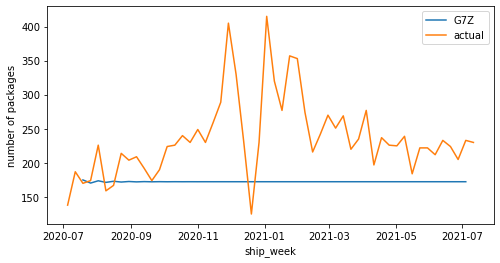

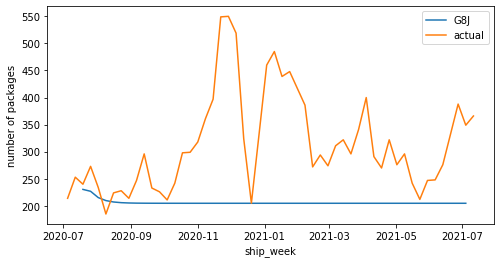

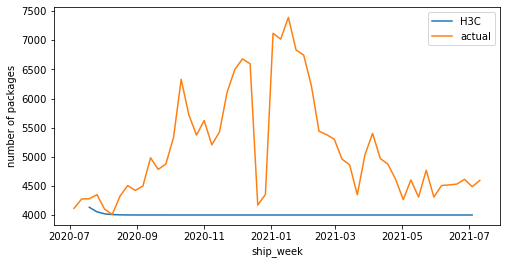

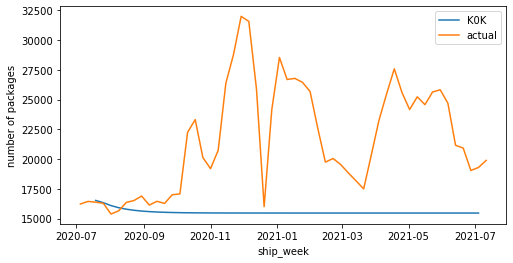

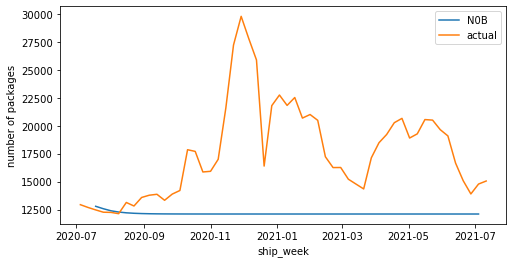

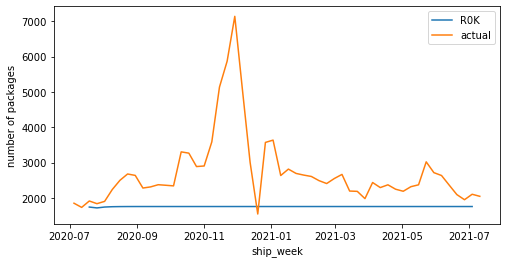

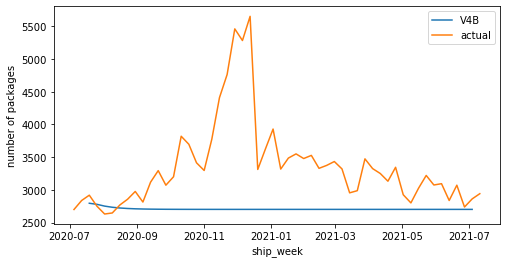

In [372]:
for key, grp in mask_pred_act.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred'], label=key)
    plt.plot(act_reset[act_reset['zipcode']==key]['ship_week'], act_reset[act_reset['zipcode']==key]['pkgs'], label='actual')
    #plt.title('Moving Average (V1) Vs Actaul')
    plt.xlabel('ship_week')
    plt.ylabel('number of packages')
    plt.legend()
    plt.show()

## Proportion visuals for 8FSA

In [153]:
pct_data1

ship_week zipcode      pkgs
0      2017-06-25     A0A  0.038180
1      2017-06-25     A0B  0.016697
2      2017-06-25     A0C  0.010742
3      2017-06-25     A0E  0.018098
4      2017-06-25     A0G  0.036195
...           ...     ...       ...
348633 2021-07-11     X0G  0.000038
348634 2021-07-11     X1A  0.050325
348635 2021-07-11     Y0A  0.000379
348636 2021-07-11     Y0B  0.001212
348637 2021-07-11     Y1A  0.067144

[348638 rows x 3 columns]

In [154]:
pct_data_index = pct_data1.set_index('ship_week')
pct_data_index

zipcode      pkgs
ship_week                   
2017-06-25     A0A  0.038180
2017-06-25     A0B  0.016697
2017-06-25     A0C  0.010742
2017-06-25     A0E  0.018098
2017-06-25     A0G  0.036195
...            ...       ...
2021-07-11     X0G  0.000038
2021-07-11     X1A  0.050325
2021-07-11     Y0A  0.000379
2021-07-11     Y0B  0.001212
2021-07-11     Y1A  0.067144

[348638 rows x 2 columns]

In [155]:
pct_actual= pct_data_index[pct_data_index.index >'2020-07-04']
pct_actual

zipcode      pkgs
ship_week                   
2020-07-05     A0A  0.037456
2020-07-05     A0B  0.017336
2020-07-05     A0C  0.010109
2020-07-05     A0E  0.016132
2020-07-05     A0G  0.034356
...            ...       ...
2021-07-11     X0G  0.000038
2021-07-11     X1A  0.050325
2021-07-11     Y0A  0.000379
2021-07-11     Y0B  0.001212
2021-07-11     Y1A  0.067144

[89203 rows x 2 columns]

In [156]:
pct_act = pct_actual[(pct_actual['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pct_act

zipcode      pkgs
ship_week                   
2020-07-05     G7Z  0.002725
2020-07-05     G8J  0.004225
2020-07-05     H0M  0.000395
2020-07-05     H3C  0.081289
2020-07-05     K0K  0.320300
...            ...       ...
2021-07-11     H3C  0.087050
2021-07-11     K0K  0.376742
2021-07-11     N0B  0.285336
2021-07-11     R0K  0.038847
2021-07-11     V4B  0.055704

[432 rows x 2 columns]

In [157]:
pct_act_reset = pct_act.reset_index()
pct_act_reset

ship_week zipcode      pkgs
0   2020-07-05     G7Z  0.002725
1   2020-07-05     G8J  0.004225
2   2020-07-05     H0M  0.000395
3   2020-07-05     H3C  0.081289
4   2020-07-05     K0K  0.320300
..         ...     ...       ...
427 2021-07-11     H3C  0.087050
428 2021-07-11     K0K  0.376742
429 2021-07-11     N0B  0.285336
430 2021-07-11     R0K  0.038847
431 2021-07-11     V4B  0.055704

[432 rows x 3 columns]

## 8 FSAs actuals

In [63]:
fsa_act = mod_actual[(mod_actual['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
fsa_act

zipcode   pkgs
ship_week                
2020-07-05     G7Z    138
2020-07-05     G8J    214
2020-07-05     H0M     20
2020-07-05     H3C   4117
2020-07-05     K0K  16222
...            ...    ...
2021-07-04     H3C   4488
2021-07-04     K0K  19299
2021-07-04     N0B  14793
2021-07-04     R0K   2109
2021-07-04     V4B   2861

[424 rows x 2 columns]

In [64]:
act_reset = fsa_act.reset_index()
act_reset

ship_week zipcode   pkgs
0   2020-07-05     G7Z    138
1   2020-07-05     G8J    214
2   2020-07-05     H0M     20
3   2020-07-05     H3C   4117
4   2020-07-05     K0K  16222
..         ...     ...    ...
419 2021-07-04     H3C   4488
420 2021-07-04     K0K  19299
421 2021-07-04     N0B  14793
422 2021-07-04     R0K   2109
423 2021-07-04     V4B   2861

[424 rows x 3 columns]

## 8 FSA pred

In [164]:
df_mask_index = df_mask.set_index('ship_week')
df_mask_index

pred zipcode
ship_week                      
2020-07-19  1841.832527     A0A
2020-07-26  1765.225603     A0A
2020-08-02  1724.586639     A0A
2020-08-09  1701.911311     A0A
2020-08-16  1689.259155     A0A
...                 ...     ...
2021-06-06   101.849107     S7C
2021-06-13   101.849107     S7C
2021-06-20   101.849107     S7C
2021-06-27   101.849107     S7C
2021-07-04   101.849107     S7C

[83077 rows x 2 columns]

In [165]:
mask_rst = df_mask_index.reset_index('ship_week')
mask_rst

ship_week         pred zipcode
0     2020-07-19  1841.832527     A0A
1     2020-07-26  1765.225603     A0A
2     2020-08-02  1724.586639     A0A
3     2020-08-09  1701.911311     A0A
4     2020-08-16  1689.259155     A0A
...          ...          ...     ...
83072 2021-06-06   101.849107     S7C
83073 2021-06-13   101.849107     S7C
83074 2021-06-20   101.849107     S7C
83075 2021-06-27   101.849107     S7C
83076 2021-07-04   101.849107     S7C

[83077 rows x 3 columns]

In [166]:
#% volume distribution/week/FSA for the predictions 
pct_fct1 =mask_rst.groupby(['ship_week','zipcode']).sum()/mask_rst.groupby(['ship_week']).sum()*100
pct_fct1

pred
ship_week  zipcode          
2020-07-19 A0A      0.036357
           A0B      0.017534
           A0C      0.009192
           A0E      0.017971
           A0G      0.031838
...                      ...
2021-07-04 X0E      0.005675
           X1A      0.059896
           Y0A      0.000341
           Y0B      0.001089
           Y1A      0.068067

[83077 rows x 1 columns]

In [169]:
pred_rst = pct_fct1.reset_index()
pred_rst

ship_week zipcode      pred
0     2020-07-19     A0A  0.036357
1     2020-07-19     A0B  0.017534
2     2020-07-19     A0C  0.009192
3     2020-07-19     A0E  0.017971
4     2020-07-19     A0G  0.031838
...          ...     ...       ...
83072 2021-07-04     X0E  0.005675
83073 2021-07-04     X1A  0.059896
83074 2021-07-04     Y0A  0.000341
83075 2021-07-04     Y0B  0.001089
83076 2021-07-04     Y1A  0.068067

[83077 rows x 3 columns]

In [168]:
pred_rst_mask = pred_rst[(pred_rst['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pred_rst_mask

ship_week zipcode      pred
338   2020-07-19     G7Z  0.003454
345   2020-07-19     G8J  0.004549
407   2020-07-19     H3C  0.081628
650   2020-07-19     K0K  0.326194
991   2020-07-19     N0B  0.252803
...          ...     ...       ...
81855 2021-07-04     H3C  0.081462
82098 2021-07-04     K0K  0.314710
82439 2021-07-04     N0B  0.246605
82620 2021-07-04     R0K  0.035870
82956 2021-07-04     V4B  0.054963

[357 rows x 3 columns]

## Actual 8FSA VS V1 proportion visuals

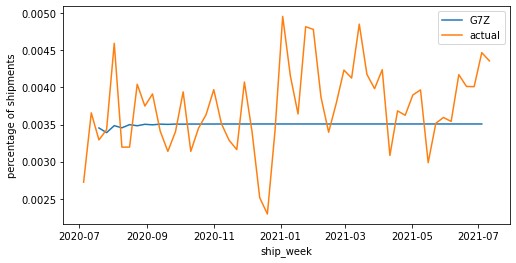

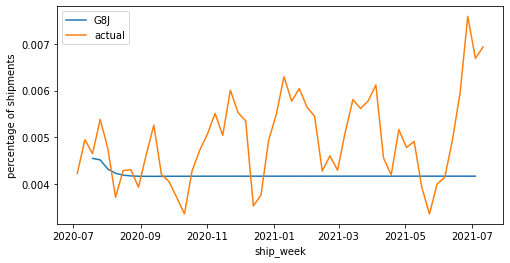

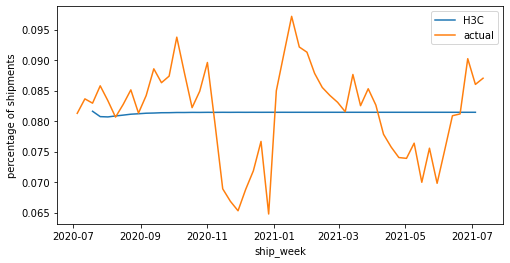

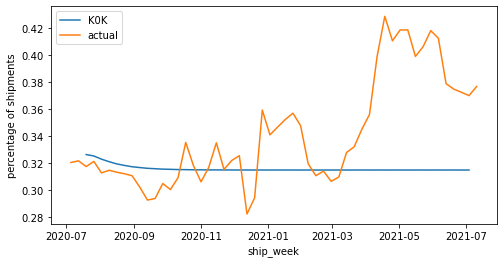

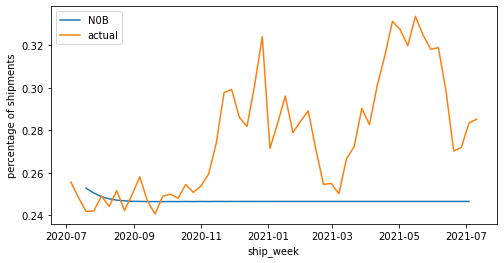

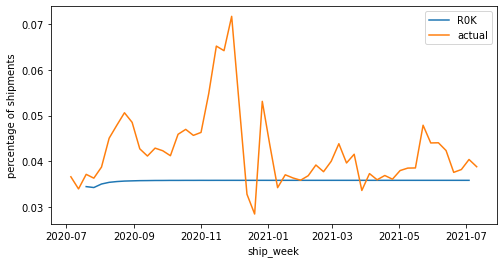

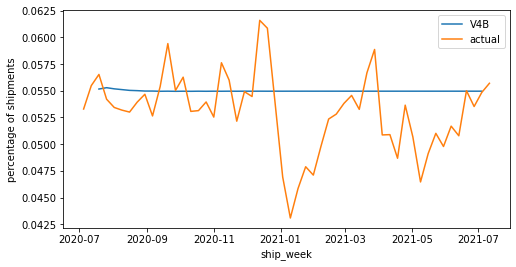

In [172]:
#fig, ax = plt.subplots(figsize=(10,4))
for key, grp in pred_rst_mask.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred'], label=key)
    plt.plot(pct_act_reset[pct_act_reset['zipcode']==key]['ship_week'], pct_act_reset[pct_act_reset['zipcode']==key]['pkgs'], label='actual')
    #plt.title('Moving Average (V1) Vs actual number of pkgs')
    plt.xlabel('ship_week')
    plt.ylabel('percentage of shipments')
    plt.legend()
    plt.show()
    #plt.close()

In [62]:
df_pred

ship_week         pred zipcode
0  2020-07-19  1841.832527     A0A
1  2020-07-26  1765.225603     A0A
2  2020-08-02  1724.586639     A0A
3  2020-08-09  1701.911311     A0A
4  2020-08-16  1689.259155     A0A
..        ...          ...     ...
47 2023-07-30   199.512830     R5R
48 2023-08-06   199.512830     R5R
49 2023-08-13   199.512830     R5R
50 2023-08-20   199.512830     R5R
51 2023-08-27   199.512830     R5R

[85956 rows x 3 columns]

In [145]:
len(df_pred.zipcode.unique())

1653

In [59]:
mask = (df_pred['ship_week'] > '2020-07-05') & (df_pred['ship_week'] <= '2021-07-04')
print(df_pred.loc[mask])

    ship_week         pred zipcode
0  2020-08-02  1798.619337     A0A
1  2020-08-09  1764.482226     A0A
2  2020-08-16  1728.938804     A0A
3  2020-08-23  1708.697847     A0A
4  2020-08-30  1697.171204     A0A
..        ...          ...     ...
44 2021-06-06  3341.440438     Y1A
45 2021-06-13  3341.440438     Y1A
46 2021-06-20  3341.440438     Y1A
47 2021-06-27  3341.440438     Y1A
48 2021-07-04  3341.440438     Y1A

[79821 rows x 3 columns]


In [60]:
df_mask = (df_pred.loc[mask])
df_mask

ship_week         pred zipcode
0  2020-08-02  1798.619337     A0A
1  2020-08-09  1764.482226     A0A
2  2020-08-16  1728.938804     A0A
3  2020-08-23  1708.697847     A0A
4  2020-08-30  1697.171204     A0A
..        ...          ...     ...
44 2021-06-06  3341.440438     Y1A
45 2021-06-13  3341.440438     Y1A
46 2021-06-20  3341.440438     Y1A
47 2021-06-27  3341.440438     Y1A
48 2021-07-04  3341.440438     Y1A

[79821 rows x 3 columns]

In [192]:
len(df_mask.zipcode.unique())

1628

## Months of Interests

In [193]:
# date_pp_v1 = df_mask[(df_mask['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# date_pp_v1

In [194]:
## v1 forecast for months of interest 
# fsa_pp_v1 = date_pp_v1[(date_pp_v1['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
# fsa_pp_v1

In [195]:
# v1 actual for months of interest 
# act_reset

In [196]:
# act_pp_v1 = act_reset[(act_reset['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# act_pp_v1

In [154]:
# pp_index = act_pp_v1.set_index('ship_week')

In [181]:
# grp1 = pp_index.groupby('zipcode')
# for key in grp1.groups.keys():
#     grp1.get_group(key).plot(title=key)

In [198]:
#fig, ax = plt.subplots(figsize=(10,4))
# # for key, grp in fsa_pp_v1.groupby(['zipcode']):
# #     fig, ax = plt.subplots(figsize=(8,4))
# #     plt.plot(grp['ship_week'], grp['pred'], label=key)
# #     plt.plot(act_pp_v1[act_pp_v1['zipcode']==key]['ship_week'], act_pp_v1[act_pp_v1['zipcode']==key]['pkgs'], label='actual')
# #     plt.legend()
#     plt.show()
#     #plt.close()

In [199]:
# sort_df = df_mask.sort_values('ship_week')
# sort_df

In [100]:
sort_df.dtypes

ship_week    datetime64[ns]
pred                float64
zipcode              object
dtype: object

In [61]:
df_mask_index = df_mask.set_index('ship_week')
df_mask_index

pred zipcode
ship_week                      
2020-08-02  1798.619337     A0A
2020-08-09  1764.482226     A0A
2020-08-16  1728.938804     A0A
2020-08-23  1708.697847     A0A
2020-08-30  1697.171204     A0A
...                 ...     ...
2021-06-06  3341.440438     Y1A
2021-06-13  3341.440438     Y1A
2021-06-20  3341.440438     Y1A
2021-06-27  3341.440438     Y1A
2021-07-04  3341.440438     Y1A

[79821 rows x 2 columns]

In [99]:
df_mask_index.dtypes

pred       float64
zipcode     object
dtype: object

In [98]:
pred_mask.dtypes

dtype('float64')

## Metrics V1

In [55]:
pct_data2 = pct2.reset_index()
pct_data2.head(10)

ship_week zipcode      pkgs
0 2017-07-09     A0A  0.000331
1 2017-07-09     A0B  0.000172
2 2017-07-09     A0C  0.000090
3 2017-07-09     A0E  0.000167
4 2017-07-09     A0G  0.000286
5 2017-07-09     A0H  0.000174
6 2017-07-09     A0J  0.000106
7 2017-07-09     A0K  0.000166
8 2017-07-09     A0L  0.000087
9 2017-07-09     A0M  0.000064

In [374]:
len(pct_data2.zipcode.unique())

1653

In [119]:
# df_pred

In [120]:
# prop_df_pred = df_pred.groupby(['ship_week','zipcode']).sum()/df_pred.groupby(['ship_week']).sum()
# prop_df_pred

In [62]:
df_mask_index = df_mask.set_index('ship_week')
df_mask_index

pred zipcode
ship_week                      
2020-08-02  1798.619337     A0A
2020-08-09  1764.482226     A0A
2020-08-16  1728.938804     A0A
2020-08-23  1708.697847     A0A
2020-08-30  1697.171204     A0A
...                 ...     ...
2021-06-06  3341.440438     Y1A
2021-06-13  3341.440438     Y1A
2021-06-20  3341.440438     Y1A
2021-06-27  3341.440438     Y1A
2021-07-04  3341.440438     Y1A

[79821 rows x 2 columns]

In [63]:
len(df_mask_index.zipcode.unique())

1629

In [64]:
prop = df_mask_index.groupby(['ship_week','zipcode']).sum()/df_mask_index.groupby(['ship_week']).sum()
prop

pred
ship_week  zipcode          
2020-08-02 A0A      0.000358
           A0B      0.000177
           A0C      0.000100
           A0E      0.000182
           A0G      0.000345
...                      ...
2021-07-04 X0E      0.000049
           X1A      0.000578
           Y0A      0.000003
           Y0B      0.000012
           Y1A      0.000678

[79821 rows x 1 columns]

In [65]:
prop_reset = prop.reset_index()
prop_reset

ship_week zipcode      pred
0     2020-08-02     A0A  0.000358
1     2020-08-02     A0B  0.000177
2     2020-08-02     A0C  0.000100
3     2020-08-02     A0E  0.000182
4     2020-08-02     A0G  0.000345
...          ...     ...       ...
79816 2021-07-04     X0E  0.000049
79817 2021-07-04     X1A  0.000578
79818 2021-07-04     Y0A  0.000003
79819 2021-07-04     Y0B  0.000012
79820 2021-07-04     Y1A  0.000678

[79821 rows x 3 columns]

In [66]:
prop_mean= prop_reset.groupby(['zipcode'], sort=False).mean()
prop_mean

pred
zipcode          
A0A      0.000342
A0B      0.000171
A0C      0.000094
A0E      0.000166
A0G      0.000326
...           ...
X0E      0.000049
X1A      0.000576
Y0A      0.000003
Y0B      0.000012
Y1A      0.000677

[1629 rows x 1 columns]

In [67]:
prop_mean_rst = prop_mean.reset_index()
prop_mean_rst

zipcode      pred
0        A0A  0.000342
1        A0B  0.000171
2        A0C  0.000094
3        A0E  0.000166
4        A0G  0.000326
...      ...       ...
1624     X0E  0.000049
1625     X1A  0.000576
1626     Y0A  0.000003
1627     Y0B  0.000012
1628     Y1A  0.000677

[1629 rows x 2 columns]

In [68]:
result_prop_v1 = pd.merge(prop_mean_rst, pct_data2,  on=["zipcode"])
result_prop_v1

zipcode      pred  ship_week      pkgs
0          A0A  0.000342 2017-07-09  0.000331
1          A0A  0.000342 2017-07-16  0.000314
2          A0A  0.000342 2017-07-23  0.000321
3          A0A  0.000342 2017-07-30  0.000360
4          A0A  0.000342 2017-08-06  0.000392
...        ...       ...        ...       ...
345343     Y1A  0.000677 2021-06-27  0.000619
345344     Y1A  0.000677 2021-07-04  0.000642
345345     Y1A  0.000677 2021-07-11  0.000671
345346     Y1A  0.000677 2021-07-18  0.000625
345347     Y1A  0.000677 2021-07-25  0.000625

[345348 rows x 4 columns]

In [69]:
result_prop_v1['diff_mix'] =result_prop_v1['pkgs'] - result_prop_v1['pred']

result_prop_v1['diff_mix']= result_prop_v1['diff_mix'].abs()

result_prop_v1

zipcode      pred  ship_week      pkgs  diff_mix
0          A0A  0.000342 2017-07-09  0.000331  0.000011
1          A0A  0.000342 2017-07-16  0.000314  0.000028
2          A0A  0.000342 2017-07-23  0.000321  0.000021
3          A0A  0.000342 2017-07-30  0.000360  0.000018
4          A0A  0.000342 2017-08-06  0.000392  0.000050
...        ...       ...        ...       ...       ...
345343     Y1A  0.000677 2021-06-27  0.000619  0.000058
345344     Y1A  0.000677 2021-07-04  0.000642  0.000035
345345     Y1A  0.000677 2021-07-11  0.000671  0.000006
345346     Y1A  0.000677 2021-07-18  0.000625  0.000052
345347     Y1A  0.000677 2021-07-25  0.000625  0.000052

[345348 rows x 5 columns]

In [70]:
result_prop_v1['APE'] = result_prop_v1['diff_mix'] / result_prop_v1['pkgs']
result_prop_v1

zipcode      pred  ship_week      pkgs  diff_mix       APE
0          A0A  0.000342 2017-07-09  0.000331  0.000011  0.034456
1          A0A  0.000342 2017-07-16  0.000314  0.000028  0.089629
2          A0A  0.000342 2017-07-23  0.000321  0.000021  0.066099
3          A0A  0.000342 2017-07-30  0.000360  0.000018  0.050304
4          A0A  0.000342 2017-08-06  0.000392  0.000050  0.127434
...        ...       ...        ...       ...       ...       ...
345343     Y1A  0.000677 2021-06-27  0.000619  0.000058  0.093943
345344     Y1A  0.000677 2021-07-04  0.000642  0.000035  0.055006
345345     Y1A  0.000677 2021-07-11  0.000671  0.000006  0.008451
345346     Y1A  0.000677 2021-07-18  0.000625  0.000052  0.083635
345347     Y1A  0.000677 2021-07-25  0.000625  0.000052  0.083003

[345348 rows x 6 columns]

In [71]:
#MAPE
mean_v1= result_prop_v1.groupby(['ship_week'])[['APE']].mean()*100
mean_v1

APE
ship_week            
2017-07-09  27.805448
2017-07-16  25.349869
2017-07-23  25.084732
2017-07-30  23.769270
2017-08-06  22.815941
...               ...
2021-06-27  13.220305
2021-07-04  12.613682
2021-07-11  11.770289
2021-07-18  12.534578
2021-07-25  12.097717

[212 rows x 1 columns]

In [72]:
mape_v1_upd = mean_v1[mean_v1.index >'2020-07-04']
mape_v1_upd

APE
ship_week            
2020-07-05   5.063976
2020-07-12   4.538349
2020-07-19   4.234467
2020-07-26   3.591233
2020-08-02   5.426052
2020-08-09   6.438459
2020-08-16   6.076091
2020-08-23   6.874564
2020-08-30   8.220647
2020-09-06   7.670755
2020-09-13   7.437369
2020-09-20   7.405649
2020-09-27   7.844703
2020-10-04   8.087420
2020-10-11  11.258456
2020-10-18   9.973197
2020-10-25   9.644182
2020-11-01  11.334401
2020-11-08  12.679530
2020-11-15  13.516868
2020-11-22  14.794888
2020-11-29  15.808963
2020-12-06  13.890907
2020-12-13  17.130505
2020-12-20  24.634462
2020-12-27  15.521836
2021-01-03  13.201798
2021-01-10  16.002876
2021-01-17  16.109935
2021-01-24  15.131610
2021-01-31  14.301675
2021-02-07  12.854880
2021-02-14  10.558663
2021-02-21  10.074683
2021-02-28   9.671494
2021-03-07  10.607478
2021-03-14  11.557109
2021-03-21  10.638266
2021-03-28  13.431127
2021-04-04  12.269230
2021-04-11  12.761556
2021-04-18  13.804433
2021-04-25  14.273455
2021-05-02  14.187208
2021-05-09  13.735283
2021-05-16  14.657861
2021-05-23  14.019419
2021-05-30  14.309029
2021-06-06  12.412994
2021-06-13  11.227415
2021-06-20  10.736902
2021-06-27  13.220305
2021-07-04  12.613682
2021-07-11  11.770289
2021-07-18  12.534578
2021-07-25  12.097717

In [73]:
def my_agg(x):
    names = {'weighted_v1_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v1_mix'])

In [74]:
wegt_v1 = result_prop_v1.groupby(["ship_week"]).apply(my_agg)*100
wegt_v1

weighted_v1_mix
ship_week                  
2017-07-09        20.883661
2017-07-16        20.468668
2017-07-23        20.167061
2017-07-30        19.709252
2017-08-06        19.283909
...                     ...
2021-06-27        10.748105
2021-07-04        10.616238
2021-07-11         9.981543
2021-07-18        10.705931
2021-07-25        10.155743

[212 rows x 1 columns]

In [75]:
wape_v1_upd = wegt_v1[wegt_v1.index >'2020-07-04']
wape_v1_upd

weighted_v1_mix
ship_week                  
2020-07-05         3.935629
2020-07-12         3.318596
2020-07-19         3.223545
2020-07-26         2.692232
2020-08-02         3.901151
2020-08-09         4.707292
2020-08-16         4.550798
2020-08-23         5.619511
2020-08-30         7.394209
2020-09-06         6.637893
2020-09-13         6.488380
2020-09-20         6.243202
2020-09-27         6.269435
2020-10-04         6.191762
2020-10-11         9.573589
2020-10-18         8.157901
2020-10-25         7.852559
2020-11-01         9.090909
2020-11-08        11.327255
2020-11-15        12.622531
2020-11-22        12.714585
2020-11-29        13.436149
2020-12-06        12.329475
2020-12-13        11.893440
2020-12-20        14.199463
2020-12-27        11.430179
2021-01-03        11.625496
2021-01-10        14.014947
2021-01-17        14.515236
2021-01-24        13.539573
2021-01-31        12.511429
2021-02-07        11.029078
2021-02-14         8.081798
2021-02-21         7.830095
2021-02-28         7.903104
2021-03-07         8.923768
2021-03-14         9.707583
2021-03-21         9.430558
2021-03-28        10.953481
2021-04-04        10.186545
2021-04-11        11.483450
2021-04-18        12.753774
2021-04-25        11.728599
2021-05-02        13.370983
2021-05-09        12.748682
2021-05-16        12.392142
2021-05-23        12.196934
2021-05-30        12.558630
2021-06-06        11.135562
2021-06-13         9.567130
2021-06-20         9.049941
2021-06-27        10.748105
2021-07-04        10.616238
2021-07-11         9.981543
2021-07-18        10.705931
2021-07-25        10.155743

## Without mean

In [76]:
result_metric_prop = pd.merge(prop_reset, pct_data2,  on=["ship_week", "zipcode"])
result_metric_prop

ship_week zipcode      pred      pkgs
0     2020-08-02     A0A  0.000358  0.000331
1     2020-08-02     A0B  0.000177  0.000157
2     2020-08-02     A0C  0.000100  0.000091
3     2020-08-02     A0E  0.000182  0.000157
4     2020-08-02     A0G  0.000345  0.000346
...          ...     ...       ...       ...
79816 2021-07-04     X0E  0.000049  0.000066
79817 2021-07-04     X1A  0.000578  0.000517
79818 2021-07-04     Y0A  0.000003  0.000002
79819 2021-07-04     Y0B  0.000012  0.000008
79820 2021-07-04     Y1A  0.000678  0.000642

[79821 rows x 4 columns]

In [77]:
#take the difference
result_metric_prop['diff_mix'] = result_metric_prop['pkgs'] - result_metric_prop['pred']

result_metric_prop['diff_mix']= result_metric_prop['diff_mix'].abs()

result_metric_prop

ship_week zipcode      pred      pkgs  diff_mix
0     2020-08-02     A0A  0.000358  0.000331  0.000027
1     2020-08-02     A0B  0.000177  0.000157  0.000020
2     2020-08-02     A0C  0.000100  0.000091  0.000008
3     2020-08-02     A0E  0.000182  0.000157  0.000025
4     2020-08-02     A0G  0.000345  0.000346  0.000001
...          ...     ...       ...       ...       ...
79816 2021-07-04     X0E  0.000049  0.000066  0.000017
79817 2021-07-04     X1A  0.000578  0.000517  0.000061
79818 2021-07-04     Y0A  0.000003  0.000002  0.000002
79819 2021-07-04     Y0B  0.000012  0.000008  0.000004
79820 2021-07-04     Y1A  0.000678  0.000642  0.000036

[79821 rows x 5 columns]

In [73]:
len(result_metric_prop.zipcode.unique())

1629

In [78]:
result_metric_prop['APE'] = result_metric_prop['diff_mix'] / result_metric_prop['pkgs']
result_metric_prop

ship_week zipcode      pred      pkgs  diff_mix       APE
0     2020-08-02     A0A  0.000358  0.000331  0.000027  0.081409
1     2020-08-02     A0B  0.000177  0.000157  0.000020  0.124958
2     2020-08-02     A0C  0.000100  0.000091  0.000008  0.091483
3     2020-08-02     A0E  0.000182  0.000157  0.000025  0.158606
4     2020-08-02     A0G  0.000345  0.000346  0.000001  0.004227
...          ...     ...       ...       ...       ...       ...
79816 2021-07-04     X0E  0.000049  0.000066  0.000017  0.257176
79817 2021-07-04     X1A  0.000578  0.000517  0.000061  0.117858
79818 2021-07-04     Y0A  0.000003  0.000002  0.000002  0.981474
79819 2021-07-04     Y0B  0.000012  0.000008  0.000004  0.478727
79820 2021-07-04     Y1A  0.000678  0.000642  0.000036  0.056793

[79821 rows x 6 columns]

In [188]:
len(result_metric_prop.zipcode.unique())

1629

## check the FSAs with high errors 

In [79]:
res = result_metric_prop.sort_values('APE', ascending=False)
res

ship_week zipcode      pred          pkgs      diff_mix           APE
34652 2020-12-27     H4Y  0.000002  2.974065e-07  1.683352e-06  5.660107e+00
31396 2020-12-13     H5B  0.000002  4.357089e-07  2.023912e-06  4.645102e+00
33023 2020-12-20     H4Y  0.000002  3.675142e-07  1.613618e-06  4.390627e+00
64482 2021-05-02     M5K  0.000004  8.662009e-07  3.450556e-06  3.983552e+00
52573 2021-03-14     H5B  0.000002  5.409007e-07  1.918793e-06  3.547404e+00
...          ...     ...       ...           ...           ...           ...
7157  2020-08-30     J9Y  0.000151  1.508809e-04  7.814858e-10  5.179487e-06
8531  2020-09-06     H2B  0.000305  3.050452e-04  1.566123e-09  5.134069e-06
13912 2020-09-27     L9M  0.000490  4.902741e-04  2.433482e-09  4.963513e-06
28410 2020-11-29     K8N  0.000948  9.484887e-04  4.580090e-09  4.828829e-06
37893 2021-01-10     H4B  0.000629  6.290923e-04  2.677390e-10  4.255957e-07

[79821 rows x 6 columns]

In [80]:
mean_error = res.groupby(['zipcode'])[['APE']].mean()

mean_error

APE
zipcode          
A0A      0.313883
A0B      0.350486
A0C      0.312160
A0E      0.339108
A0G      0.309341
...           ...
X0E      0.185767
X1A      0.237091
Y0A      0.434729
Y0B      0.406489
Y1A      0.196244

[1629 rows x 1 columns]

In [81]:
mean_error.sort_values('APE', ascending=False)

APE
zipcode          
H5B      1.060941
H4Y      0.751715
L5P      0.627576
M5K      0.557607
X0C      0.518541
...           ...
N2T      0.043581
K1Y      0.043231
L3R      0.041570
L3P      0.041314
K2G      0.040501

[1629 rows x 1 columns]

## MAPE V1

In [82]:
#MAPE
mean_result_prop= result_metric_prop.groupby(['ship_week'])[['APE']].mean()*100
mean_result_prop

APE
ship_week            
2020-08-02   5.238208
2020-08-09   6.598215
2020-08-16   5.978015
2020-08-23   6.813941
2020-08-30   8.205209
2020-09-06   7.639005
2020-09-13   7.418126
2020-09-20   7.390444
2020-09-27   7.842115
2020-10-04   8.084427
2020-10-11  11.270744
2020-10-18   9.984097
2020-10-25   9.666365
2020-11-01  11.336795
2020-11-08  12.699890
2020-11-15  13.548376
2020-11-22  14.819905
2020-11-29  15.843427
2020-12-06  13.933584
2020-12-13  17.136849
2020-12-20  24.648840
2020-12-27  15.546591
2021-01-03  13.228847
2021-01-10  16.009030
2021-01-17  16.139246
2021-01-24  15.143326
2021-01-31  14.330077
2021-02-07  12.865163
2021-02-14  10.577577
2021-02-21  10.082311
2021-02-28   9.692201
2021-03-07  10.626332
2021-03-14  11.580668
2021-03-21  10.658096
2021-03-28  13.447511
2021-04-04  12.289926
2021-04-11  12.785927
2021-04-18  13.835737
2021-04-25  14.295536
2021-05-02  14.206637
2021-05-09  13.753002
2021-05-16  14.658594
2021-05-23  14.043961
2021-05-30  14.317259
2021-06-06  12.438063
2021-06-13  11.262624
2021-06-20  10.772906
2021-06-27  13.254066
2021-07-04  12.645078

In [76]:
mape_pp_v1 = mean_result_prop.reset_index()
mape_pp_v1.head()

ship_week       APE
0 2020-07-19  4.700628
1 2020-07-26  5.356581
2 2020-08-02  6.016879
3 2020-08-09  6.883209
4 2020-08-16  6.707883

In [285]:
# mape_pp_v1 = mean_result_prop.reset_index()

In [287]:
# mape_pp_v1 = mape_pp_v1[(mape_pp_v1['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# mape_pp_v1

## WAPE V1

In [83]:
def my_agg(x):
    names = {'weighted_avg_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_avg_mix'])

In [84]:
wape_V1 = result_metric_prop.groupby(["ship_week"]).apply(my_agg)*100
wape_V1

weighted_avg_mix
ship_week                   
2020-08-02          3.441550
2020-08-09          4.544871
2020-08-16          4.352284
2020-08-23          5.517384
2020-08-30          7.371077
2020-09-06          6.591860
2020-09-13          6.486136
2020-09-20          6.230135
2020-09-27          6.281555
2020-10-04          6.188973
2020-10-11          9.591901
2020-10-18          8.178208
2020-10-25          7.876355
2020-11-01          9.103544
2020-11-08         11.355847
2020-11-15         12.655291
2020-11-22         12.742958
2020-11-29         13.465539
2020-12-06         12.373109
2020-12-13         11.922319
2020-12-20         14.216227
2020-12-27         11.457152
2021-01-03         11.654764
2021-01-10         14.034712
2021-01-17         14.549705
2021-01-24         13.564644
2021-01-31         12.538312
2021-02-07         11.048945
2021-02-14          8.097537
2021-02-21          7.841794
2021-02-28          7.913997
2021-03-07          8.940552
2021-03-14          9.725978
2021-03-21          9.448766
2021-03-28         10.981281
2021-04-04         10.215073
2021-04-11         11.507203
2021-04-18         12.785326
2021-04-25         11.758515
2021-05-02         13.400033
2021-05-09         12.775883
2021-05-16         12.399525
2021-05-23         12.225802
2021-05-30         12.574309
2021-06-06         11.158981
2021-06-13          9.604044
2021-06-20          9.089127
2021-06-27         10.778889
2021-07-04         10.643895

In [138]:
# wape_pp_v1 = wape_V1.reset_index()

In [288]:
# wape_pp_v1 = wape_pp_v1[(wape_pp_v1['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# wape_pp_v1

In [89]:
wape_V1.dtypes

weighted_avg_mix    float64
dtype: object

## Multiprocessing for all FSAs 

In [56]:
# mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
# mod_df

In [58]:
#mod_df['ship_week'] = pd.to_datetime(mod_df['ship_week'])

In [166]:
#  mod_df = mod_df[((mod_df['ship_week']).dt.day != 1) |
#                  ((mod_df['ship_week']).dt.month != 1)]

In [45]:
mod_df.shape

(348432, 2)

In [68]:
num_fsa = int(len(mod_df.zipcode.unique()) / mp.cpu_count()) + 1

In [69]:
num_fsa

207

In [63]:
grp_fsa = list(zip_longest(*(iter(pd.unique(mod_df['zipcode'])),) * num_fsa))
#grp_fsa

In [88]:
pd.unique(mod_df['zipcode'])

(1652,)

In [64]:
df_dict = dict(tuple(mod_df.groupby('zipcode')))
#df_dict

In [65]:
# fsa_list = [pd.concat([df_dict.get(key) for key in mod_df]) for mod_df in grp_fsa]
# #fsa_list
fsa_list = [pd.concat([df_dict.get(key) for key in y]) for y in grp_fsa]
#fsa_list

In [66]:
p = mp.Pool(mp.cpu_count())

In [70]:
# results = p.map(run_V1_models, fsa_list)......error

## V2 Version 

In [88]:
# define function 
def run_V2_models(df):
    
    #input from the model 
    
    #df = df.set_index('ship_week')
    train_data = df[-4*212:160]
    test_data = df[-52:]
    fcst_data = df[-3*52:]
    
    
    train_data1 = train_data.iloc[:,1]
    test_data1 = test_data.iloc[:,1]
    fcst = fcst_data.iloc[:,1]
    
    best_model = SARIMAX(train_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
    pred = best_model.predict(start=160, end=160+52-1)
    pred = pd.DataFrame(pred)
    pred.columns= ['pred_V2']
    pred['zipcode'] = df['zipcode'].unique()[0]
    
    
    best_model_fct = SARIMAX(fcst, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
    fct = best_model_fct.predict(start=160, end=160+352-1)
    fct = pd.DataFrame(fct) 
    fct.columns = ['pred_V2']
    fct['zipcode'] = df['zipcode'].unique()[0]
    
    return pred, fct
   

In [ ]:
#Tunning 
#(2,0,0) (0,1,1)52.......cannnot run this 
#(0,1,1) (0,1,1)52
#(0,1,1) (0,1,0)52

In [89]:
zipcodes = list(mod_df.zipcode.unique())
len(zipcodes)

1653

In [90]:
predictions2=[]
forecasts2=[]

for zipcode in zipcodes:
    sub_df = mod_df[mod_df['zipcode']==zipcode]
    
    pred, fct = run_V2_models(sub_df)
    
    #result.append([post_code, pred_model, forecast])
    predictions2.append(pred)
    forecasts2.append(fct)

In [1]:
forecasts2[0]

NameError: name 'forecasts2' is not defined

In [ ]:
predictions2[0].head()

## V2 Metrics

In [84]:
#get a concertinate format that will work and change the name of the index colunm

pred_V2 = pd.DataFrame(columns=['index', 'pred_V2', 'zipcode'])
pred_V2
for i in range(len(predictions2)):
    pred_V2 = pred_V2.append([predictions2[i].reset_index()])    
    

In [23]:
#pred_V2

In [86]:
pred_V2['index'] = pd.to_datetime(pred_V2['index'], errors='coerce')
pred_V2

index      pred_V2 zipcode
0  2020-07-19  1386.472752     A0A
1  2020-07-26  1263.307550     A0A
2  2020-08-02  1430.264873     A0A
3  2020-08-09  1418.986253     A0A
4  2020-08-16  1452.327222     A0A
..        ...          ...     ...
47 2023-07-30   360.810531     R5R
48 2023-08-06   375.965734     R5R
49 2023-08-13   357.022420     R5R
50 2023-08-20   391.043124     R5R
51 2023-08-27   427.050686     R5R

[85956 rows x 3 columns]

In [87]:
pred_V2.rename({'index': 'ship_week'}, axis=1, inplace=True)
pred_V2.head(10)

ship_week      pred_V2 zipcode
0 2020-07-19  1386.472752     A0A
1 2020-07-26  1263.307550     A0A
2 2020-08-02  1430.264873     A0A
3 2020-08-09  1418.986253     A0A
4 2020-08-16  1452.327222     A0A
5 2020-08-23  1620.591190     A0A
6 2020-08-30  1544.693732     A0A
7 2020-09-06  1644.277991     A0A
8 2020-09-13  1601.795738     A0A
9 2020-09-20  1625.564318     A0A

In [90]:
v2_mask_index = pred_V2.set_index('ship_week')
v2_mask_index

pred_V2 zipcode
ship_week                      
2020-07-19  1386.472752     A0A
2020-07-26  1263.307550     A0A
2020-08-02  1430.264873     A0A
2020-08-09  1418.986253     A0A
2020-08-16  1452.327222     A0A
...                 ...     ...
2023-07-30   360.810531     R5R
2023-08-06   375.965734     R5R
2023-08-13   357.022420     R5R
2023-08-20   391.043124     R5R
2023-08-27   427.050686     R5R

[85956 rows x 2 columns]

In [91]:
prop_v2 = v2_mask_index.groupby(['ship_week','zipcode']).sum()/v2_mask_index.groupby(['ship_week']).sum()*100
prop_v2

pred_V2
ship_week  zipcode           
2020-07-19 A0A       0.031535
           A0B       0.013596
           A0C       0.008812
           A0E       0.016235
           A0G       0.030348
...                       ...
2023-08-20 R5P      19.248158
           R5R      51.026004
           R5T      29.725837
2023-08-27 R5P      26.568188
           R5R      73.431812

[85176 rows x 1 columns]

In [400]:
prop_v2_reset = prop_v2.reset_index()
prop_v2_reset

ship_week zipcode    pred_V2
0     2020-07-19     A0A   0.031535
1     2020-07-19     A0B   0.013596
2     2020-07-19     A0C   0.008812
3     2020-07-19     A0E   0.016235
4     2020-07-19     A0G   0.030348
...          ...     ...        ...
85171 2023-08-20     R5P  19.248158
85172 2023-08-20     R5R  51.026004
85173 2023-08-20     R5T  29.725837
85174 2023-08-27     R5P  26.568188
85175 2023-08-27     R5R  73.431812

[85176 rows x 3 columns]

In [255]:
## v2 actuals for 8 FSA
pred_rst_v2 = prop_v2_reset[(prop_v2_reset['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pred_rst_v2

ship_week zipcode   pred_V2
338   2020-07-19     G7Z  0.003439
345   2020-07-19     G8J  0.004197
407   2020-07-19     H3C  0.083996
650   2020-07-19     K0K  0.337199
991   2020-07-19     N0B  0.257450
...          ...     ...       ...
83484 2021-07-11     H3C  0.080501
83727 2021-07-11     K0K  0.323503
84068 2021-07-11     N0B  0.241641
84249 2021-07-11     R0K  0.033766
84586 2021-07-11     V4B  0.059364

[364 rows x 3 columns]

In [256]:
pct_act_reset

ship_week zipcode      pkgs
0   2020-07-05     G7Z  0.002725
1   2020-07-05     G8J  0.004225
2   2020-07-05     H0M  0.000395
3   2020-07-05     H3C  0.081289
4   2020-07-05     K0K  0.320300
..         ...     ...       ...
427 2021-07-11     H3C  0.087050
428 2021-07-11     K0K  0.376742
429 2021-07-11     N0B  0.285336
430 2021-07-11     R0K  0.038847
431 2021-07-11     V4B  0.055704

[432 rows x 3 columns]

## V2 Visuals....actual vs forecasts 

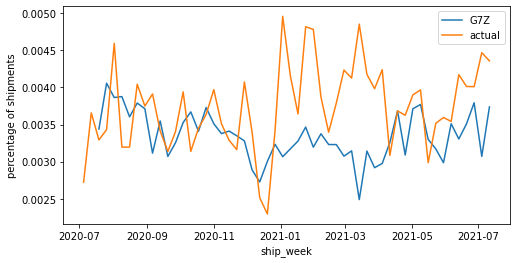

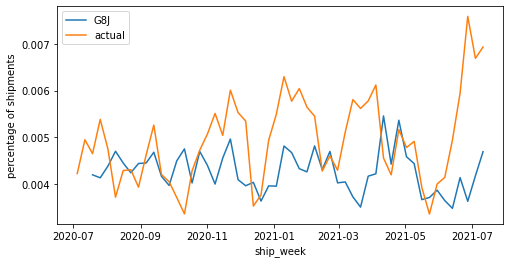

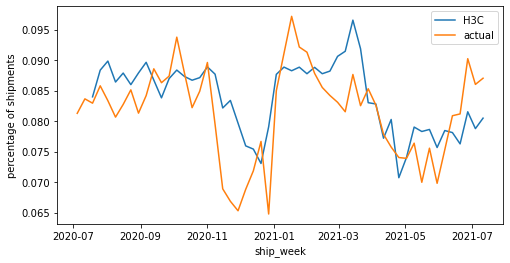

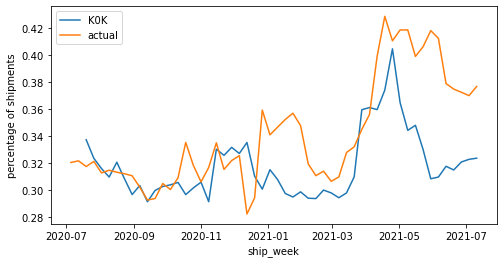

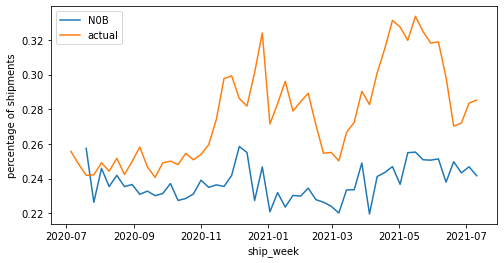

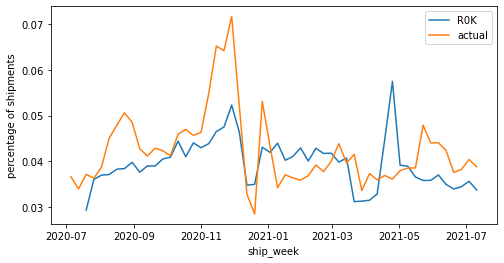

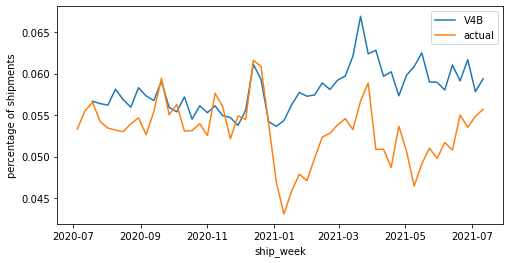

In [236]:
#fig, ax = plt.subplots(figsize=(10,4))
for key, grp in pred_rst_v2.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
    plt.plot(pct_act_reset[pct_act_reset['zipcode']==key]['ship_week'], pct_act_reset[pct_act_reset['zipcode']==key]['pkgs'], label='actual')
    #plt.title('V2 Model Version and Actual pkgs')
    plt.xlabel ('ship_week')
    plt.ylabel ('percentage of shipments')
    plt.legend()
    plt.show()
    #plt.close()

## Absolute VS V2 Visuals

In [237]:
#actualu
act_reset

ship_week zipcode   pkgs
0   2020-07-05     G7Z    138
1   2020-07-05     G8J    214
2   2020-07-05     H0M     20
3   2020-07-05     H3C   4117
4   2020-07-05     K0K  16222
..         ...     ...    ...
427 2021-07-11     H3C   4596
428 2021-07-11     K0K  19891
429 2021-07-11     N0B  15065
430 2021-07-11     R0K   2051
431 2021-07-11     V4B   2941

[432 rows x 3 columns]

In [238]:
#forecast
v2_index = v2_mask_index.reset_index()
v2_index

ship_week      pred_V2 zipcode
0     2020-07-19  1386.472752     A0A
1     2020-07-26  1263.307550     A0A
2     2020-08-02  1430.264873     A0A
3     2020-08-09  1418.986253     A0A
4     2020-08-16  1452.327222     A0A
...          ...          ...     ...
85951 2023-07-30   360.810531     R5R
85952 2023-08-06   375.965734     R5R
85953 2023-08-13   357.022420     R5R
85954 2023-08-20   391.043124     R5R
85955 2023-08-27   427.050686     R5R

[85956 rows x 3 columns]

In [239]:
fsa_v2 = v2_index[(v2_index['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
fsa_v2

ship_week      pred_V2 zipcode
17576 2020-07-19   151.212898     G7Z
17577 2020-07-26   176.894731     G7Z
17578 2020-08-02   165.873584     G7Z
17579 2020-08-09   174.872179     G7Z
17580 2020-08-16   162.872085     G7Z
...          ...          ...     ...
78671 2021-06-13  4299.418402     V4B
78672 2021-06-20  4059.418402     V4B
78673 2021-06-27  4079.418402     V4B
78674 2021-07-04  4101.418402     V4B
78675 2021-07-11  4239.418402     V4B

[416 rows x 3 columns]

In [240]:
fsa_v2_hom = v2_index[(v2_index['zipcode'].isin(['H0M']))]
fsa_v2_hom.head()

ship_week    pred_V2 zipcode
18980       NaT  16.444351     H0M
18981       NaT  11.010136     H0M
18982       NaT  23.696365     H0M
18983       NaT  12.627720     H0M
18984       NaT  18.612702     H0M

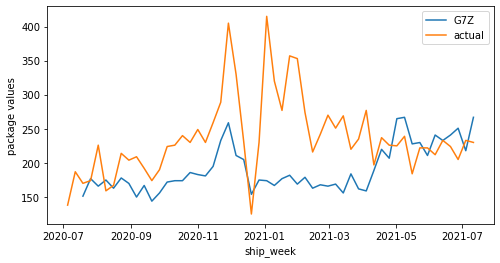

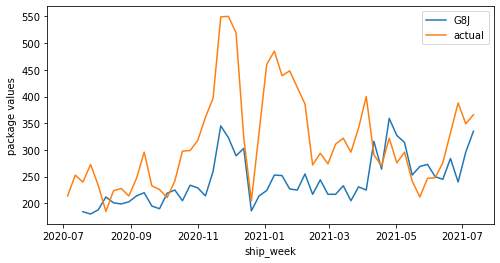

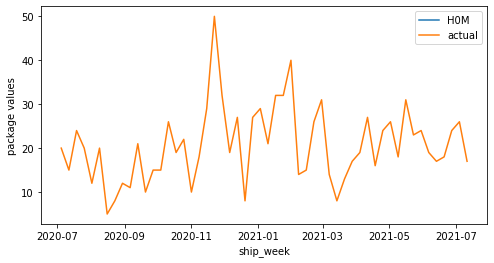

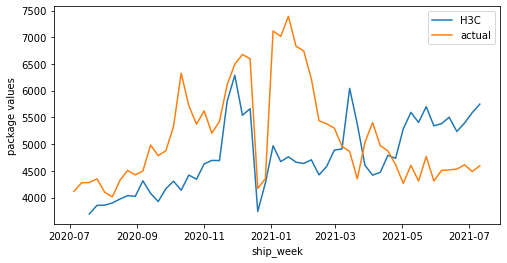

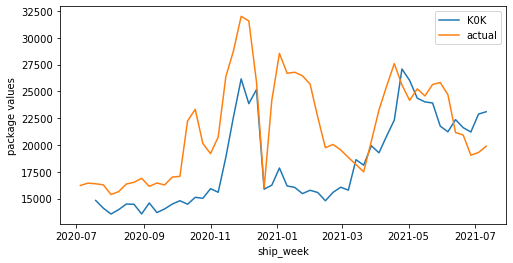

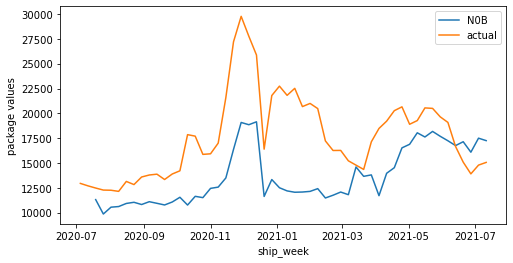

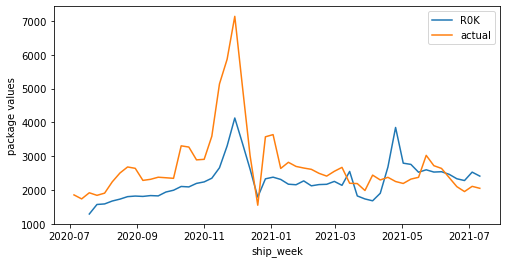

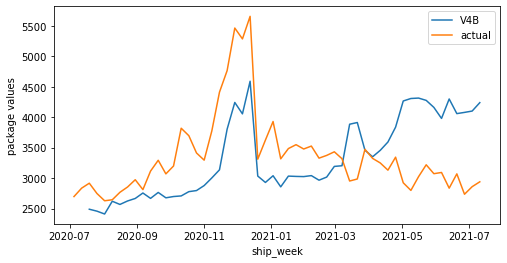

In [243]:
for key, grp in fsa_v2.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
    plt.plot(act_reset[act_reset['zipcode']==key]['ship_week'], act_reset[act_reset['zipcode']==key]['pkgs'], label='actual')
    #plt.title('V2 Model Version and Actual pkgs')
    plt.xlabel('ship_week')
    plt.ylabel('package values')
    plt.legend()
    plt.show()

## V2 MONTH OF INTEREST

In [267]:
# v2_index

In [268]:
# date_pp_v2 = v2_index[(v2_index['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# date_pp_v2

In [269]:
## v1 forecast for months of interest 
# fsa_pp_v2 = date_pp_v2[(date_pp_v2['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
# fsa_pp_v2

In [270]:
# act_pp_v1

In [271]:
#fig, ax = plt.subplots(figsize=(10,4))
# for key, grp in fsa_pp_v2.groupby(['zipcode']):
#     fig, ax = plt.subplots(figsize=(8,4))
#     plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
#     plt.plot(act_pp_v1[act_pp_v1['zipcode']==key]['ship_week'], act_pp_v1[act_pp_v1['zipcode']==key]['pkgs'], label='actual')
#     plt.legend()
#     plt.show()

## V2 Metrics calculation

In [92]:
prop_v2_new = v2_mask_index.groupby(['ship_week','zipcode']).sum()/v2_mask_index.groupby(['ship_week']).sum()
prop_v2_new

pred_V2
ship_week  zipcode          
2020-07-19 A0A      0.000315
           A0B      0.000136
           A0C      0.000088
           A0E      0.000162
           A0G      0.000303
...                      ...
2023-08-20 R5P      0.192482
           R5R      0.510260
           R5T      0.297258
2023-08-27 R5P      0.265682
           R5R      0.734318

[85176 rows x 1 columns]

In [135]:
prop_v2_ind = prop_v2_new.reset_index()
prop_v2_ind

ship_week zipcode   pred_V2
0     2020-07-19     A0A  0.000315
1     2020-07-19     A0B  0.000136
2     2020-07-19     A0C  0.000088
3     2020-07-19     A0E  0.000162
4     2020-07-19     A0G  0.000303
...          ...     ...       ...
85171 2023-08-20     R5P  0.192482
85172 2023-08-20     R5R  0.510260
85173 2023-08-20     R5T  0.297258
85174 2023-08-27     R5P  0.265682
85175 2023-08-27     R5R  0.734318

[85176 rows x 3 columns]

In [143]:
mask_v2 = (prop_v2_ind['ship_week'] > '2020-07-05') & (prop_v2_ind['ship_week'] <= '2021-07-04')
print(prop_v2_ind.loc[mask_v2])

       ship_week zipcode   pred_V2
0     2020-07-19     A0A  0.000315
1     2020-07-19     A0B  0.000136
2     2020-07-19     A0C  0.000088
3     2020-07-19     A0E  0.000162
4     2020-07-19     A0G  0.000303
...          ...     ...       ...
83072 2021-07-04     X0E  0.000068
83073 2021-07-04     X1A  0.000594
83074 2021-07-04     Y0A  0.000003
83075 2021-07-04     Y0B  0.000010
83076 2021-07-04     Y1A  0.000672

[83077 rows x 3 columns]


In [146]:
pred2 = prop_v2_ind.loc[mask_v2]
pred2

ship_week zipcode   pred_V2
0     2020-07-19     A0A  0.000315
1     2020-07-19     A0B  0.000136
2     2020-07-19     A0C  0.000088
3     2020-07-19     A0E  0.000162
4     2020-07-19     A0G  0.000303
...          ...     ...       ...
83072 2021-07-04     X0E  0.000068
83073 2021-07-04     X1A  0.000594
83074 2021-07-04     Y0A  0.000003
83075 2021-07-04     Y0B  0.000010
83076 2021-07-04     Y1A  0.000672

[83077 rows x 3 columns]

In [147]:
mean_v2= pred2.groupby(['zipcode'], sort=False).mean()
mean_v2

pred_V2
zipcode          
A0A      0.000353
A0B      0.000165
A0C      0.000095
A0E      0.000176
A0G      0.000331
...           ...
X1A      0.000601
Y0A      0.000004
Y0B      0.000011
Y1A      0.000697
S7C      0.000025

[1629 rows x 1 columns]

In [148]:
mean_v2_rst = mean_v2.reset_index()

In [149]:
pred_v2_merge = pd.merge(mean_v2_rst, pct_data2,  on=["zipcode"])
pred_v2_merge

zipcode   pred_V2  ship_week      pkgs
0          A0A  0.000353 2017-06-25  0.000382
1          A0A  0.000353 2017-07-02  0.000402
2          A0A  0.000353 2017-07-09  0.000331
3          A0A  0.000353 2017-07-16  0.000314
4          A0A  0.000353 2017-07-23  0.000321
...        ...       ...        ...       ...
345341     S7C  0.000025 2021-06-13  0.000023
345342     S7C  0.000025 2021-06-20  0.000023
345343     S7C  0.000025 2021-06-27  0.000025
345344     S7C  0.000025 2021-07-04  0.000029
345345     S7C  0.000025 2021-07-11  0.000027

[345346 rows x 4 columns]

In [150]:
pred_v2_merge['pct_mix'] = pred_v2_merge['pkgs'] - pred_v2_merge['pred_V2']

pred_v2_merge['pct_mix']= pred_v2_merge['pct_mix'].abs()

pred_v2_merge

zipcode   pred_V2  ship_week      pkgs       pct_mix
0          A0A  0.000353 2017-06-25  0.000382  2.920298e-05
1          A0A  0.000353 2017-07-02  0.000402  4.918728e-05
2          A0A  0.000353 2017-07-09  0.000331  2.175044e-05
3          A0A  0.000353 2017-07-16  0.000314  3.850298e-05
4          A0A  0.000353 2017-07-23  0.000321  3.157062e-05
...        ...       ...        ...       ...           ...
345341     S7C  0.000025 2021-06-13  0.000023  1.102137e-06
345342     S7C  0.000025 2021-06-20  0.000023  1.446509e-06
345343     S7C  0.000025 2021-06-27  0.000025  2.841934e-07
345344     S7C  0.000025 2021-07-04  0.000029  4.010493e-06
345345     S7C  0.000025 2021-07-11  0.000027  2.153347e-06

[345346 rows x 5 columns]

In [151]:
pred_v2_merge['APE'] = pred_v2_merge['pct_mix'] / pred_v2_merge['pkgs']
pred_v2_merge

zipcode   pred_V2  ship_week      pkgs       pct_mix       APE
0          A0A  0.000353 2017-06-25  0.000382  2.920298e-05  0.076487
1          A0A  0.000353 2017-07-02  0.000402  4.918728e-05  0.122422
2          A0A  0.000353 2017-07-09  0.000331  2.175044e-05  0.065741
3          A0A  0.000353 2017-07-16  0.000314  3.850298e-05  0.122583
4          A0A  0.000353 2017-07-23  0.000321  3.157062e-05  0.098342
...        ...       ...        ...       ...           ...       ...
345341     S7C  0.000025 2021-06-13  0.000023  1.102137e-06  0.046999
345342     S7C  0.000025 2021-06-20  0.000023  1.446509e-06  0.062603
345343     S7C  0.000025 2021-06-27  0.000025  2.841934e-07  0.011442
345344     S7C  0.000025 2021-07-04  0.000029  4.010493e-06  0.140409
345345     S7C  0.000025 2021-07-11  0.000027  2.153347e-06  0.080632

[345346 rows x 6 columns]

In [152]:
#MAPE
mape_v2_new = pred_v2_merge.groupby(['ship_week'])[['APE']].mean()*100
mape_v2_new

APE
ship_week            
2017-06-25  23.682913
2017-07-02  23.602215
2017-07-09  28.499446
2017-07-16  25.327934
2017-07-23  25.107676
...               ...
2021-06-13  11.874916
2021-06-20  11.502657
2021-06-27  14.374712
2021-07-04  13.626638
2021-07-11  12.999066

[212 rows x 1 columns]

In [153]:
mape_v2_upd = mape_v2_new[mape_v2_new.index >'2020-07-04']
mape_v2_upd

APE
ship_week            
2020-07-05   6.194433
2020-07-12   6.097187
2020-07-19   6.867227
2020-07-26   7.474032
2020-08-02   7.831552
2020-08-09   7.969016
2020-08-16   7.668059
2020-08-23   8.031993
2020-08-30   8.721880
2020-09-06   8.693799
2020-09-13   8.307173
2020-09-20   8.341041
2020-09-27   8.397631
2020-10-04   9.187239
2020-10-11  12.295517
2020-10-18  10.477230
2020-10-25   9.952232
2020-11-01  11.702357
2020-11-08  12.970592
2020-11-15  13.248707
2020-11-22  14.087591
2020-11-29  15.309980
2020-12-06  13.856442
2020-12-13  17.525277
2020-12-20  26.444255
2020-12-27  15.614177
2021-01-03  14.499536
2021-01-10  17.607146
2021-01-17  17.528984
2021-01-24  16.662334
2021-01-31  15.716177
2021-02-07  14.201639
2021-02-14  11.683852
2021-02-21  10.991368
2021-02-28  10.295438
2021-03-07  11.181367
2021-03-14  12.287005
2021-03-21  11.116701
2021-03-28  14.387624
2021-04-04  12.839136
2021-04-11  13.688291
2021-04-18  14.467154
2021-04-25  14.881925
2021-05-02  14.697086
2021-05-09  14.302766
2021-05-16  15.058168
2021-05-23  14.267501
2021-05-30  14.506601
2021-06-06  12.850969
2021-06-13  11.874916
2021-06-20  11.502657
2021-06-27  14.374712
2021-07-04  13.626638
2021-07-11  12.999066

In [169]:
def my_agg(x):
    names = {'weighted_v2_upd': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v2_upd'])

In [170]:
wape_v2_upd = pred_v2_merge.groupby(["ship_week"]).apply(my_agg)*100
wape_v2_upd

weighted_v2_upd
ship_week                  
2017-06-25        20.037444
2017-07-02        19.901189
2017-07-09        20.948980
2017-07-16        20.312209
2017-07-23        20.052767
...                     ...
2021-06-13         9.427737
2021-06-20         9.170041
2021-06-27        11.212956
2021-07-04        10.782974
2021-07-11        10.379186

[212 rows x 1 columns]

In [171]:
wape_new_v2 = wape_v2_upd[wape_v2_upd.index >'2020-07-04']
wape_new_v2

weighted_v2_upd
ship_week                  
2020-07-05         3.993876
2020-07-12         3.979479
2020-07-19         4.574490
2020-07-26         4.838561
2020-08-02         4.997893
2020-08-09         5.460968
2020-08-16         5.186175
2020-08-23         6.091565
2020-08-30         7.047455
2020-09-06         6.815014
2020-09-13         6.479885
2020-09-20         6.467741
2020-09-27         6.021458
2020-10-04         6.478041
2020-10-11         9.749078
2020-10-18         8.087018
2020-10-25         7.487433
2020-11-01         8.662616
2020-11-08        10.922793
2020-11-15        11.739946
2020-11-22        11.517216
2020-11-29        12.410716
2020-12-06        11.357934
2020-12-13        11.372470
2020-12-20        15.214090
2020-12-27        11.587378
2021-01-03        12.147098
2021-01-10        14.391351
2021-01-17        14.912712
2021-01-24        13.969025
2021-01-31        12.816014
2021-02-07        11.352846
2021-02-14         8.266251
2021-02-21         7.795308
2021-02-28         7.575586
2021-03-07         8.758173
2021-03-14         9.734616
2021-03-21         9.155989
2021-03-28        11.092455
2021-04-04        10.111395
2021-04-11        11.317721
2021-04-18        12.537031
2021-04-25        11.490342
2021-05-02        13.112399
2021-05-09        12.452638
2021-05-16        12.051660
2021-05-23        11.992453
2021-05-30        12.283482
2021-06-06        10.939083
2021-06-13         9.427737
2021-06-20         9.170041
2021-06-27        11.212956
2021-07-04        10.782974
2021-07-11        10.379186

In [96]:
#take the difference
metric_pred_v2['pct_mix'] = metric_pred_v2['pkgs'] - metric_pred_v2['pred_V2']

metric_pred_v2['pct_mix']= metric_pred_v2['pct_mix'].abs()

metric_pred_v2

ship_week zipcode   pred_V2      pkgs       pct_mix
0     2020-07-19     A0A  0.000315  0.000337  2.154424e-05
1     2020-07-19     A0B  0.000136  0.000161  2.522628e-05
2     2020-07-19     A0C  0.000088  0.000095  7.004859e-06
3     2020-07-19     A0E  0.000162  0.000171  8.713846e-06
4     2020-07-19     A0G  0.000303  0.000323  1.946864e-05
...          ...     ...       ...       ...           ...
84702 2021-07-11     X0E  0.000062  0.000064  2.107036e-06
84703 2021-07-11     X1A  0.000619  0.000503  1.159744e-04
84704 2021-07-11     Y0A  0.000004  0.000004  4.387902e-07
84705 2021-07-11     Y0B  0.000011  0.000012  1.352577e-06
84706 2021-07-11     Y1A  0.000669  0.000671  2.778281e-06

[84707 rows x 5 columns]

In [97]:
metric_pred_v2['APE'] = metric_pred_v2['pct_mix'] / metric_pred_v2['pkgs']
metric_pred_v2

ship_week zipcode   pred_V2      pkgs       pct_mix       APE
0     2020-07-19     A0A  0.000315  0.000337  2.154424e-05  0.063949
1     2020-07-19     A0B  0.000136  0.000161  2.522628e-05  0.156507
2     2020-07-19     A0C  0.000088  0.000095  7.004859e-06  0.073641
3     2020-07-19     A0E  0.000162  0.000171  8.713846e-06  0.050939
4     2020-07-19     A0G  0.000303  0.000323  1.946864e-05  0.060284
...          ...     ...       ...       ...           ...       ...
84702 2021-07-11     X0E  0.000062  0.000064  2.107036e-06  0.032719
84703 2021-07-11     X1A  0.000619  0.000503  1.159744e-04  0.230453
84704 2021-07-11     Y0A  0.000004  0.000004  4.387902e-07  0.115835
84705 2021-07-11     Y0B  0.000011  0.000012  1.352577e-06  0.111582
84706 2021-07-11     Y1A  0.000669  0.000671  2.778281e-06  0.004138

[84707 rows x 6 columns]

## Check the FSA with high error

In [98]:
res_v2 =metric_pred_v2.sort_values('APE', ascending=False)
#res_v2.head(30)

In [99]:
mean_error_v2 = res_v2.groupby(['zipcode'])[['APE']].mean()

mean_error_v2

APE
zipcode          
A0A      0.271103
A0B      0.337772
A0C      0.280581
A0E      0.280034
A0G      0.280966
...           ...
X0E      0.174983
X1A      0.262693
Y0A      0.621300
Y0B      0.419692
Y1A      0.242018

[1630 rows x 1 columns]

In [101]:
mean_sort = mean_error_v2.sort_values('APE', ascending=False)
mean_sort.head()

APE
zipcode          
M5K      4.792415
M5X      3.327213
M5L      3.235950
V7X      3.179864
H5B      3.062064

## mape

In [102]:
#MAPE
mape_v2 = metric_pred_v2.groupby(['ship_week'])[['APE']].mean()*100
mape_v2

APE
ship_week            
2020-07-19   8.743046
2020-07-26   7.765013
2020-08-02   8.101022
2020-08-09   7.841814
2020-08-16   8.128136
2020-08-23   7.885823
2020-08-30   8.940825
2020-09-06   8.973864
2020-09-13   8.049243
2020-09-20   8.336683
2020-09-27   8.334954
2020-10-04   9.116794
2020-10-11  12.572263
2020-10-18  10.674651
2020-10-25  10.038838
2020-11-01  11.671977
2020-11-08  12.003698
2020-11-15  10.809203
2020-11-22  12.290723
2020-11-29  12.911689
2020-12-06  12.812898
2020-12-13  16.185076
2020-12-20  21.836857
2020-12-27  15.267677
2021-01-03  14.768091
2021-01-10  17.128857
2021-01-17  18.250645
2021-01-24  16.559243
2021-01-31  17.015989
2021-02-07  14.236998
2021-02-14  12.090159
2021-02-21  11.227151
2021-02-28  11.269190
2021-03-07  13.128891
2021-03-14  19.578950
2021-03-21  17.592747
2021-03-28  20.011987
2021-04-04  19.169335
2021-04-11  19.618979
2021-04-18  18.736517
2021-04-25  21.186681
2021-05-02  17.797467
2021-05-09  16.589139
2021-05-16  17.914183
2021-05-23  16.320735
2021-05-30  16.099979
2021-06-06  15.148498
2021-06-13  15.684756
2021-06-20  15.386103
2021-06-27  17.607927
2021-07-04  16.225879
2021-07-11  15.260984

In [279]:
# mape_rst = mape_v2.reset_index()

In [280]:
# mape_pp_v2 = mape_rst[(mape_rst['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# mape_pp_v2

## wape

In [103]:
def my_agg(x):
    names = {'weighted_v2_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v2_mix'])

In [104]:
wape_v2 = metric_pred_v2.groupby(["ship_week"]).apply(my_agg)*100
wape_v2

weighted_v2_mix
ship_week                  
2020-07-19         6.862407
2020-07-26         5.364092
2020-08-02         4.746872
2020-08-09         5.402453
2020-08-16         5.417966
2020-08-23         5.944641
2020-08-30         6.906555
2020-09-06         6.821797
2020-09-13         6.167854
2020-09-20         6.392359
2020-09-27         6.071328
2020-10-04         6.683072
2020-10-11         9.973511
2020-10-18         8.386237
2020-10-25         8.075733
2020-11-01         8.575504
2020-11-08        10.702217
2020-11-15         9.367962
2020-11-22         9.064763
2020-11-29         9.131698
2020-12-06         9.212876
2020-12-13        10.046651
2020-12-20        11.739769
2020-12-27        10.663288
2021-01-03        12.314498
2021-01-10        14.312033
2021-01-17        15.982267
2021-01-24        14.517140
2021-01-31        13.888658
2021-02-07        11.571985
2021-02-14         8.855280
2021-02-21         8.703037
2021-02-28         8.821794
2021-03-07        10.947046
2021-03-14        14.761356
2021-03-21        12.812435
2021-03-28        13.401415
2021-04-04        13.100609
2021-04-11        12.483412
2021-04-18        12.412184
2021-04-25        12.998312
2021-05-02        13.065242
2021-05-09        12.275290
2021-05-16        12.815364
2021-05-23        11.850674
2021-05-30        11.524173
2021-06-06        11.191768
2021-06-13        11.205618
2021-06-20        11.285899
2021-06-27        12.344236
2021-07-04        12.039698
2021-07-11        11.195506

In [281]:
# wape_rst = wape_v2.reset_index()

In [284]:
# wape_pp_v2 = wape_rst[(wape_rst['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# wape_pp_v2

In [ ]:
# mod_20 = mod_df[(mod_df['zipcode'].isin(['H4T','B1M','V6C','H3A',
#                                                 'Y0A','T0P','X0C','B1W','H3B',
#                                                 'K1P','K1A', 'L5P','H4Y',
#                                                 'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
# mod_20

In [316]:
mod_actual

zipcode  pkgs
ship_week               
2020-07-05     A0A  1897
2020-07-05     A0B   878
2020-07-05     A0C   512
2020-07-05     A0E   817
2020-07-05     A0G  1740
...            ...   ...
2021-07-04     X0G     2
2021-07-04     X1A  2695
2021-07-04     Y0A     9
2021-07-04     Y0B    41
2021-07-04     Y1A  3348

[87550 rows x 2 columns]

In [328]:
high_v2 = mod_actual[(mod_actual['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
high_v2

zipcode  pkgs
ship_week               
2020-07-05     B1M   122
2020-07-05     B1W   331
2020-07-05     H3A  1378
2020-07-05     H3B   703
2020-07-05     H4T   410
...            ...   ...
2021-07-04     V6C  1244
2021-07-04     V7X    88
2021-07-04     V7Y    36
2021-07-04     X0C   594
2021-07-04     Y0A     9

[1060 rows x 2 columns]

In [330]:
high_rst= high_v2.reset_index()
high_rst

ship_week zipcode  pkgs
0    2020-07-05     B1M   122
1    2020-07-05     B1W   331
2    2020-07-05     H3A  1378
3    2020-07-05     H3B   703
4    2020-07-05     H4T   410
...         ...     ...   ...
1055 2021-07-04     V6C  1244
1056 2021-07-04     V7X    88
1057 2021-07-04     V7Y    36
1058 2021-07-04     X0C   594
1059 2021-07-04     Y0A     9

[1060 rows x 3 columns]

In [315]:
pred_V2

ship_week      pred_V2 zipcode
0  2020-07-12  2456.989629     A0A
1  2020-07-19  1822.657344     A0A
2  2020-07-26  1616.625538     A0A
3  2020-08-02  1725.292643     A0A
4  2020-08-09  1673.011336     A0A
..        ...          ...     ...
47 2023-07-30   356.299618     R5R
48 2023-08-06   371.565487     R5R
49 2023-08-13   352.662550     R5R
50 2023-08-20   386.697985     R5R
51 2023-08-27   422.710922     R5R

[85956 rows x 3 columns]

In [331]:
high_pred = pred_V2[(pred_V2['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
high_pred

ship_week     pred_V2 zipcode
0  2020-07-12  181.260903     B1M
1  2020-07-19  128.717529     B1M
2  2020-07-26  109.196318     B1M
3  2020-08-02  119.035252     B1M
4  2020-08-09  117.693961     B1M
..        ...         ...     ...
47 2021-06-06   22.489147     Y0A
48 2021-06-13   25.489147     Y0A
49 2021-06-20   33.489147     Y0A
50 2021-06-27   21.489147     Y0A
51 2021-07-04   20.489147     Y0A

[1040 rows x 3 columns]

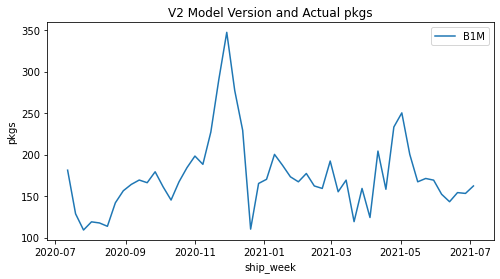

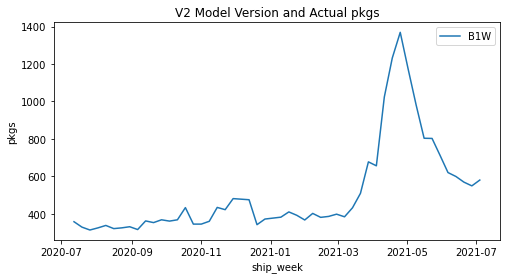

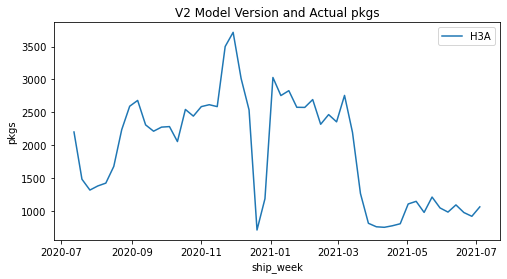

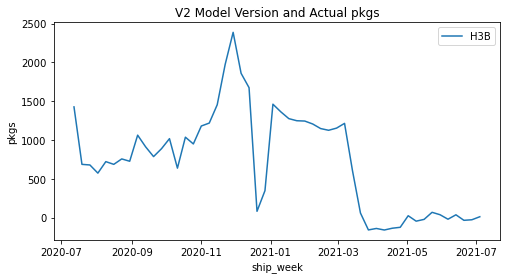

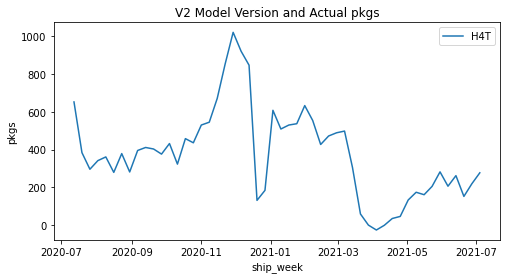

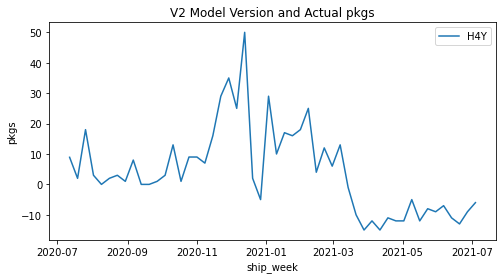

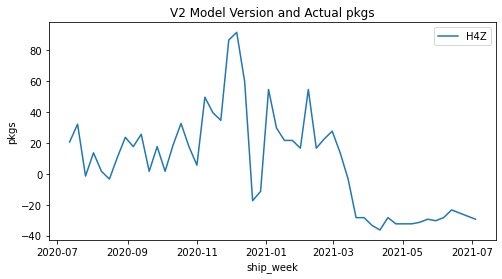

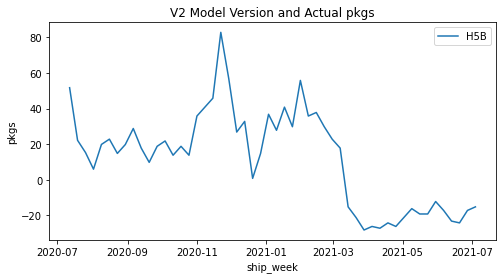

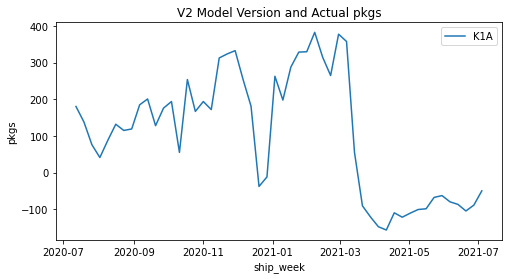

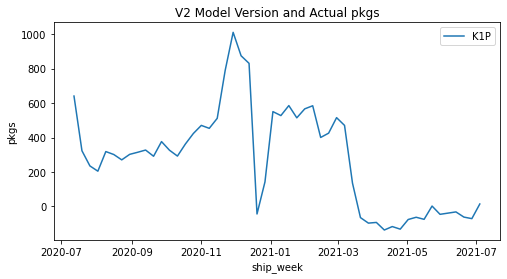

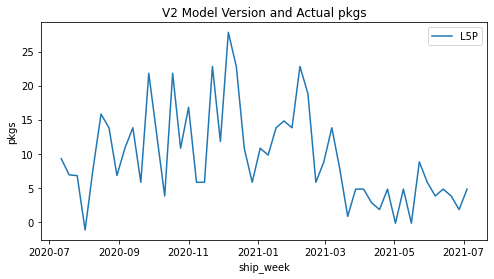

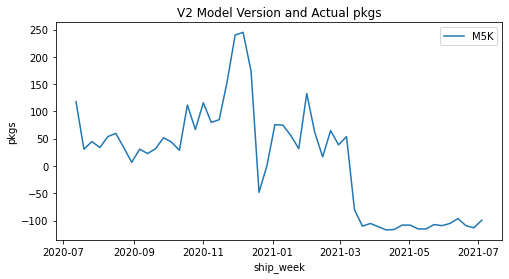

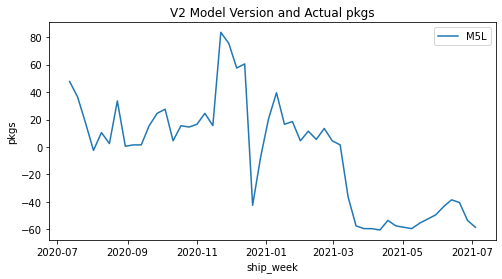

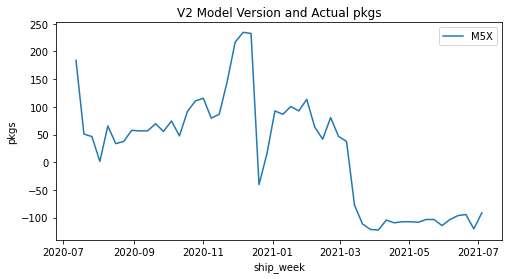

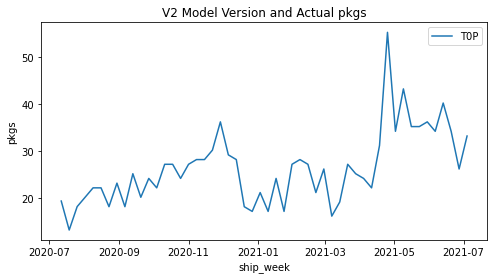

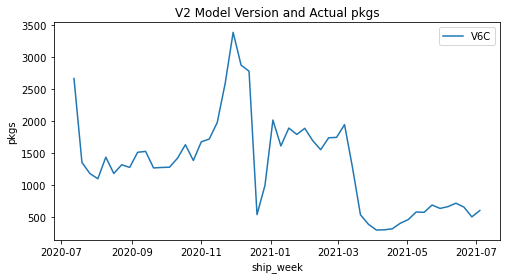

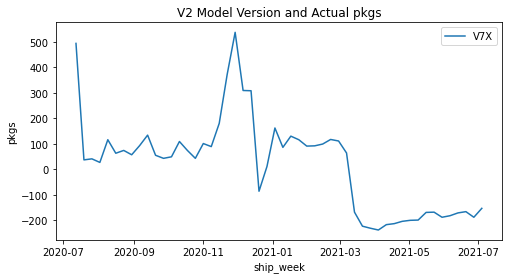

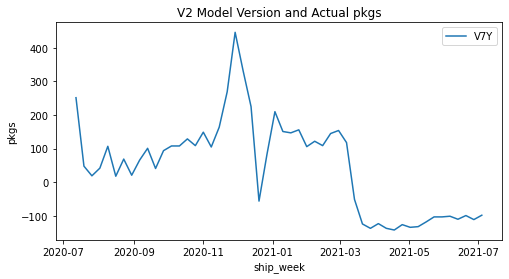

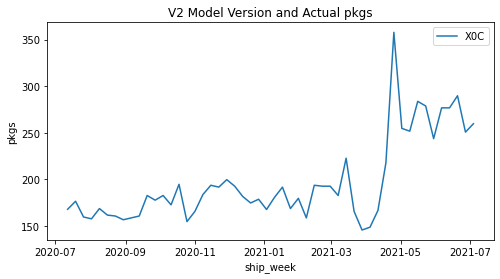

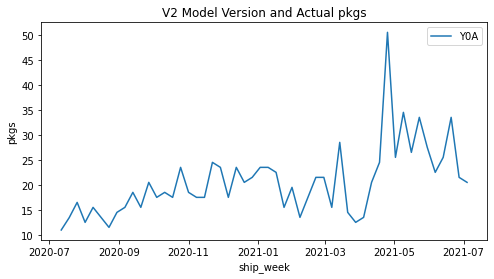

In [337]:
for key, grp in high_pred.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
    #plt.plot([high_rst['zipcode']==key]['ship_week'], high_rst[high_rst['zipcode']==key]['pkgs'], label='actual')
    plt.title('V2 Model Version and Actual pkgs')
    plt.xlabel('ship_week')
    plt.ylabel('pkgs')
    plt.legend()
    plt.show()

## Multiprocessing Review

In [22]:
# define function 
def run_V2_models(df):
    
    zipcode = df[0]
    df = df[1]

    
    #input from the model 
    try:
        
    #df = df.set_index('ship_week')
        train_data = df[-4*212:160]
        test_data = df[-52:]
        fcst_data = df[-3*52:]
    
    
        train_data1 = train_data.iloc[:,1]
        test_data1 = test_data.iloc[:,1]
        fcst = fcst_data.iloc[:,1]
    
        best_model = SARIMAX(train_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        
        pred = best_model.predict(start=160, end=160+52-1)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
    
    
        best_model_fct = SARIMAX(fcst, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        fct = best_model_fct.predict(start=160, end=160+352-1)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    
    except:
        print(df['zipcode'].unique()[0])
        pred = np.full(len(test_data1), np.nan)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
        fct = np.full(len(fcst), np.nan)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    return pred, fct

In [76]:
# result = run_V2_models(mod_df[mod_df['zipcode']=='R0K'])
# result

In [224]:
#207 into 8 parts 
# num_fsa = int(len(mod_df.zipcode.unique()) / mp.cpu_count()) + 1
# num_fsa

In [201]:
#list of the FSA
#grp_fsa = list(zip_longest(*(iter(pd.unique(mod_df['zipcode'])),) * num_fsa))
#grp_fsa

In [210]:
#grp_fsa = list(pd.unique(mod_df['zipcode']))
#grp_fsa

In [211]:
## covert list of FSAs into a dict
# df_dict = dict(tuple(mod_df.groupby('zipcode')))
#df_dict

In [220]:
#fsa_list = [pd.concat([df_dict.get(key) for key in y]) for y in grp_fsa]
#fsa_list

In [23]:
 p = mp.Pool(mp.cpu_count())

In [24]:
results = p.map(run_V2_models, mod_df.groupby('zipcode'))

In [45]:
#results[0]

In [33]:
results_pred=[]
results_fct=[]

for res in results:
    
    pred = res[0]
    fct = res[1]
    
    results_pred.append(pred)
    results_fct.append(fct)

In [35]:
#results_pred

In [37]:
#results_fct

In [40]:
def run_V2(df):
    
    zipcode = df[0]
    df = df[1]

    
    #input from the model 
    try:
        
    #df = df.set_index('ship_week')
        train_data = df[-4*212:160]
        test_data = df[-52:]
        fcst_data = df[-3*52:]
    
    
        train_data1 = train_data.iloc[:,1]
        test_data1 = test_data.iloc[:,1]
        fcst = fcst_data.iloc[:,1]
    
        best_model = SARIMAX(train_data1, order=(0, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        
        pred = best_model.predict(start=160, end=160+52-1)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
    
    
        best_model_fct = SARIMAX(fcst, order=(0, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        fct = best_model_fct.predict(start=160, end=160+352-1)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    
    except:
        print(df['zipcode'].unique()[0])
        pred = np.full(len(test_data1), np.nan)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
        fct = np.full(len(fcst), np.nan)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    return pred, fct

In [41]:
p = mp.Pool(mp.cpu_count())

In [42]:
results = p.map(run_V2, mod_df.groupby('zipcode'))

In [9]:
#results

## Prophet Model 

In [29]:
#pip install pystan

In [30]:
#pip install fbprophet

In [32]:
# from fbprophet import Prophet 
# from datetime import datetime

In [31]:
#pip install plotly 

In [36]:
# train_data = post_code[-4*212:156]
# test_data = post_code[-52:]
# fcst_data = post_code[-3*52:]

In [33]:
# train = train_data.iloc[:,1]
# train

In [23]:
#dir(prophet)

In [40]:
#train['ds'] = train['ship_week']
#train['y'] = train['pkgs']
#train.columns = ['ds', 'y']
#train.head()

In [34]:
# data = train.to_frame()
# data_train = data.reset_index()
# data_train.columns =['ship_week', 'pkgs_num']
# data_train.head()

In [35]:
# data_train.columns = ['ds', 'y']
# data_train.head()

In [38]:
#data_train.dtypes

In [28]:
# #perform Box-Cox transformation on original data
# from scipy.stats import boxcox

# #transformed_data, best_lambda = boxcox(data_train['y']) 

# data_train['y'], lam = boxcox(data_train['y'])

In [36]:
#$data_train.tail()

In [37]:
#data_train.shape

In [26]:
# #new_model_test = prophet()
# #new_model_test.fit(data_train)
# #rom fbprophet import prophet
# m = Prophet()
# m.fit(data_train)

In [25]:

# future = m.make_future_dataframe(periods=352, freq='W')
# #future = (start=156, end=156+352-1)
# future.tail()

In [24]:
# forecast = m.predict(future)
# forecast